# HOG Features

## import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import random
import time
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import utils
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# helper functions 

# Code provided by original author of GTSRB dataset
# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def getAugImageLabel(imgName):
    return int(imgName.split('_')[0])

def readAugTrafficSigns(rootpath):
    images = [] # images
    labels = [] # corresponding labels
    all_images = list(os.listdir(rootpath))
    num_examples = len(all_images)
    random.shuffle(all_images)
    
    for index in range(num_examples):
        img_path = os.path.join(rootpath, all_images[index])
        images.append(plt.imread(img_path))
        labels.append(getAugImageLabel(all_images[index]))
    return images, labels

# The following code is based on
# https://github.com/shravankumar147/gtsrb-smai/blob/master/docs/MLP%2BClassfier%2Bon%2BHOG%2BFeatures/MLP%20Classfier%20on%20HOG%20Features.md
# with modificaitons for Python3 support.
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def get_csv(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]


def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box')
    plt.show()
    
# Functions for testimages    
def loadtestimages_from_path(testpath):
    print("[INFO] reading all test images from directory")
    gtFile = get_csv(testpath)
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';', quoting=csv.QUOTE_NONE)
    next(reader)
    testfiles = list(reader)
    timg = []
    testimg = []
    tlbl = []
    for i in testfiles:
    #     print (i[0],i[-1])
        fname = os.path.join(testpath,i[0])
        timg.append(fname)
        tim = plt.imread(fname)
        testimg.append(tim)
        label = i[-1]
        tlbl.append(label)
    np.save("Image_n_Labels/testimagenames.npy",timg)
    np.save("Image_n_Labels/testimages.npy",testimg)
    np.save("Image_n_Labels/testimagelabels.npy",tlbl)
    return timg, testimg, tlbl
    
def loadtestimages_from_npy():
    print("[INFO] loading testing images")
    timg = np.load("Image_n_Labels/testimagenames.npy", allow_pickle=True)
    testimg = np.load("Image_n_Labels/testimages.npy", allow_pickle=True)
    tlbl = np.load("Image_n_Labels/testimagelabels.npy")
    return timg, testimg, tlbl

## Read Official Hog Features

In [3]:
def readTrafficSignsHog(rootpath, featurepath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../dataset/GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    hogfeat_official = [] # images
    hoglabels_official = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        prefix_hog = featurepath + '/' + format(c, '05d') + '/'
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            fileName = prefix_hog + row[0].rstrip("ppm") + "txt" # swap ppm for txt extension
            features = []
            with open(fileName) as fp:
                line = fp.readline()
                while line:
                    line = fp.readline()
                    if len(line.strip()) > 0:
                        features.append(float(line))
            hogfeat_official.append(features)
            hoglabels_official.append(row[7]) # the 8th column is the label
        gtFile.close()
    return hogfeat_official, hoglabels_official

def readTrafficSignsHogTest(testpath):
    print("[INFO] reading all test hog features from directory")
    gtFile = get_csv(testpath)
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';', quoting=csv.QUOTE_NONE)
    next(reader)
    testfiles = list(reader)
    timg = []
    testimg = []
    tlbl = []
    for i in testfiles:
    #     print (i[0],i[-1])
        fname = os.path.join(testpath,i[0].rstrip("ppm") + "txt")
        features = []
        with open(fname) as fp:
            line = fp.readline()
            while line:
                line = fp.readline()
                if len(line.strip()) > 0:
                    features.append(float(line))
        timg.append(fname)
        testimg.append(features)
        label = i[-1]
        tlbl.append(label)
    np.save("Image_n_Labels/testofficialhogfeaturenames.npy",timg)
    np.save("Image_n_Labels/testofficialhogfeatures.npy",testimg)
    np.save("Image_n_Labels/testofficialhoglabels.npy",tlbl)
    return timg, testimg, tlbl

In [4]:
hogfeat_official, hoglabels_official = readTrafficSignsHog('../GTSRB/Final_Training/Images', '../GTSRB/Final_Training/HOG/HOG_02')

In [5]:
_, hogfeat_official_test, hoglabels_official_test = readTrafficSignsHogTest('../GTSRB/Final_Test/HOG/HOG_02')

[INFO] reading all test hog features from directory


## Read and Save Training Data

In [6]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy", allow_pickle=True)
    y = np.load("Image_n_Labels/trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    X, y = readTrafficSigns('../GTSRB/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",X)
    np.save("Image_n_Labels/trainLabels.npy",y)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


## Read Augmented Training Data

In [7]:
if os.path.isfile("Image_n_Labels/trainAugImages.npy") &  os.path.isfile("Image_n_Labels/trainAugLabels.npy") :
    trainAugImages = np.load("Image_n_Labels/trainAugImages.npy", allow_pickle=True)
    trainAugLabels = np.load("Image_n_Labels/trainAugLabels.npy", allow_pickle=True)
    print("[INFO] Training augmented images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of augmented training Images {} \nNumber of Labels {}".format(len(trainAugImages), len(trainAugLabels)))
else:    
    # training images and labels
    trainAugImages, trainAugLabels = readAugTrafficSigns('data/train_aug')
    np.save("Image_n_Labels/trainAugImages.npy",trainAugImages)
    np.save("Image_n_Labels/trainAugLabels.npy",trainAugLabels)
    print("[INFO] training augmented images and labels are read from the dataset directory")
    print("[INFO] training augmented images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training augmented labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training augmented images and labels are loaded in variables ==> X,y
[INFO] Number of augmented training Images 45468 
Number of Labels 45468


/home/ken/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


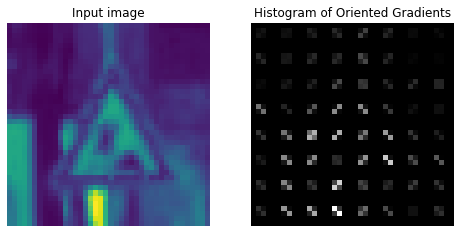

1568


In [8]:
# simple test on single image for HoG features
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
# gI2 = cv2.resize(grayim, (40, 40), interpolation = cv2.INTER_CUBIC)
# Original parms
# (H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
#     cells_per_block=(2, 2), transform_sqrt=True, visualise=True)

# HOG 2 from http://www.lara.prd.fr/_media/users/ijcnn.pdf
(H, hogImage) = feature.hog(gI1, orientations=8, pixels_per_cell=(5,5),
                            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
# hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(gI1, hogImage)
print(len(H))

## Read and Save Test Data

In [8]:
testpath="../GTSRB/Final_Test/Images/"
if os.path.isfile("Image_n_Labels/testimagenames.npy") and os.path.isfile("Image_n_Labels/testimages.npy") and os.path.isfile("Image_n_Labels/testimagelabels.npy"):
    timg, testimg, tlbl = loadtestimages_from_npy()
else:
    timg, testimg, tlbl = loadtestimages_from_path(testpath)

[INFO] loading testing images


## Process and Save HOG For Training

In [10]:
def process_save_hog(images_in, features_out, viz_out, rescale_intensity=True):
    if os.path.isfile(features_out) and os.path.isfile(viz_out):
        print("loading from file ... ")
        hogfeat = np.load(features_out)
        hogviz = np.load(viz_out)

        print("HoG features are loaded")
        print("HoG visualizations are loaded")
    else:
        print(features_out + " does not found")
        hogfeat = []
        hogviz = []
        for i in range(0,len(images_in)):
            # show an update every 1,000 images
            if i > 0 and i % 1000 == 0:
                print("[INFO] processed {}/{}".format(i, len(images_in)))
            I = images_in[i]
            grayim = rgb2gray(I)
            grayim = transform.resize(grayim,(40,40))

            # TODO: try HOG2 from http://www.lara.prd.fr/_media/users/ijcnn.pdf
            (H_5x5, hogImage) = feature.hog(grayim, orientations=8, pixels_per_cell=(5, 5),
                cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
            if rescale_intensity:
                hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
            else:
                hogImage = hogImage.astype("uint8")
            hogviz.append(hogImage)
            hogfeat.append(H_5x5)
            # save the features using numpy save with .npy extention 
            # which reduced the storage space by 4times compared to pickle
        np.save(features_out, hogfeat)
        np.save(viz_out, hogviz)
        print(features_out + " are saved")  
        print(viz_out + " are saved")
    return hogfeat, hogviz

In [11]:
hogfeat, hogviz = process_save_hog(X, "HoGFeatures/HoG2features.npy", "HoGFeatures/HoG2visualize.npy")

loading from file ... 
HoG features are loaded
HoG visualizations are loaded


In [11]:
hogfeat_no_intense, hogviz_no_intense = process_save_hog(X, "HoGFeatures/HoG2featuresNoIntense.npy", "HoGFeatures/HoG2visualizeNoIntense.npy")

HoGFeatures/HoG2featuresNoIntense.npy does not found
[INFO] processed 1000/39209
[INFO] processed 2000/39209
[INFO] processed 3000/39209
[INFO] processed 4000/39209
[INFO] processed 5000/39209
[INFO] processed 6000/39209
[INFO] processed 7000/39209
[INFO] processed 8000/39209
[INFO] processed 9000/39209
[INFO] processed 10000/39209
[INFO] processed 11000/39209
[INFO] processed 12000/39209
[INFO] processed 13000/39209
[INFO] processed 14000/39209
[INFO] processed 15000/39209
[INFO] processed 16000/39209
[INFO] processed 17000/39209
[INFO] processed 18000/39209
[INFO] processed 19000/39209
[INFO] processed 20000/39209
[INFO] processed 21000/39209
[INFO] processed 22000/39209
[INFO] processed 23000/39209
[INFO] processed 24000/39209
[INFO] processed 25000/39209
[INFO] processed 26000/39209
[INFO] processed 27000/39209
[INFO] processed 28000/39209
[INFO] processed 29000/39209
[INFO] processed 30000/39209
[INFO] processed 31000/39209
[INFO] processed 32000/39209
[INFO] processed 33000/39209

## Process and Save Augmented HOG For Training

In [12]:
hogfeat_aug, hogviz_aug = process_save_hog(trainAugImages, "HoGFeatures/HoG2featuresAug.npy", "HoGFeatures/HoG2visualizeAug.npy")

loading from file ... 
HoG features are loaded
HoG visualizations are loaded


## Process and Save HOG For Testing

In [13]:
hogfeat_test, hogviz_test = process_save_hog(testimg, "HoGFeatures/HoG2features_test.npy", "HoGFeatures/HoG2visualize_test.npy")

loading from file ... 
HoG features are loaded
HoG visualizations are loaded


In [12]:
hogfeat_test_no_intense, hogviz_test_no_intense = process_save_hog(testimg, "HoGFeatures/HoG2featuresTestNoIntense.npy", "HoGFeatures/HoG2visualizeTestNoIntense.npy")

HoGFeatures/HoG2featuresTestNoIntense.npy does not found
[INFO] processed 1000/12630
[INFO] processed 2000/12630
[INFO] processed 3000/12630
[INFO] processed 4000/12630
[INFO] processed 5000/12630
[INFO] processed 6000/12630
[INFO] processed 7000/12630
[INFO] processed 8000/12630
[INFO] processed 9000/12630
[INFO] processed 10000/12630
[INFO] processed 11000/12630
[INFO] processed 12000/12630
HoGFeatures/HoG2featuresTestNoIntense.npy are saved
HoGFeatures/HoG2visualizeTestNoIntense.npy are saved


## Create Train, Validation, Test 

In [14]:
# Training
trainData = np.array(hogfeat).astype("float")
trainLabels = y.astype("float")

# Testing
testData = np.array(hogfeat_test).astype("float")
testLabels = np.array(tlbl).astype("float")

# (trainDataShuffled, _, trainLabelsShuffled, _) = train_test_split(trainData, trainLabels,
#      test_size=None, random_state=84)

(trainDataShuffled, trainLabelsShuffled) = utils.shuffle(trainData, trainLabels)

In [15]:
trainData.shape

(39209, 1568)

In [16]:
trainDataShuffled.shape

(39209, 1568)

## Model Training

In [49]:
clf = neighbors.KNeighborsClassifier()
clf.fit(trainData, trainLabels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
clf_svm = svm.SVC()
clf_svm.fit(trainData, trainLabels)

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
save = False
if save:
    with open('knn_model.pickle', 'wb') as handle:
        pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('svm_model.pickle', 'wb') as handle:
        pickle.dump(clf_svm, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('svm_linear_model.pickle', 'wb') as handle:
        pickle.dump(clf_svm_linear, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('knn_model.pickle', 'rb') as handle:
        clf = pickle.load(handle)
    
    with open('svm_model.pickle', 'rb') as handle:
        clf_svm = pickle.load(handle)
        
    with open('svm_linear_model.pickle', 'rb') as handle:
        clf_svm_linear = pickle.load(handle)

In [ ]:
clf_svm_linear = svm.LinearSVC(max_iter=10000)
clf_svm_linear.fit(trainData, trainLabels)
with open('svm_linear_model.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
clf_svm_linear2 = svm.LinearSVC(max_iter=100000)
clf_svm_linear2.fit(trainData, trainLabels)
with open('svm_linear_model_2.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
clf_svm_linear3 = svm.LinearSVC(max_iter=10000, loss='hinge')
clf_svm_linear3.fit(trainData, trainLabels)
with open('svm_linear_model_3.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
clf_svm_linear4 = svm.LinearSVC(max_iter=10000, tol=1e-5)
clf_svm_linear4.fit(trainData, trainLabels)
with open('svm_linear_model_4.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
clf_svm_linear5 = svm.LinearSVC(max_iter=100000, tol=1e-5)
clf_svm_linear5.fit(trainData, trainLabels)
with open('svm_linear_model_5.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
clf_rfc = ensemble.RandomForestClassifier()
clf_rfc.fit(trainData, trainLabels)
with open('rfc_model.pickle', 'wb') as handle:
    pickle.dump(clf_rfc, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
clf_rfc2 = ensemble.RandomForestClassifier(n_estimators=100)
clf_rfc2.fit(trainData, trainLabels)
with open('rfc_model2.pickle', 'wb') as handle:
    pickle.dump(clf_rfc2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
clf_rfc3 = ensemble.RandomForestClassifier(n_estimators=200)
clf_rfc3.fit(trainData, trainLabels)
with open('rfc_model3.pickle', 'wb') as handle:
    pickle.dump(clf_rfc3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
clf_rfc4 = ensemble.RandomForestClassifier(n_estimators=500)
clf_rfc4.fit(trainData, trainLabels)
with open('rfc_model4.pickle', 'wb') as handle:
    pickle.dump(clf_rfc4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
clf_rfc5 = ensemble.RandomForestClassifier(min_samples_split=500, n_estimators=500, n_jobs=8)
clf_rfc5.fit(trainData, trainLabels)
with open('rfc_model5.pickle', 'wb') as handle:
    pickle.dump(clf_rfc5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
clf_rfc6 = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=8)
clf_rfc6.fit(trainData, trainLabels)
with open('rfc_model6.pickle', 'wb') as handle:
    pickle.dump(clf_rfc6, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# With HOG2
clf_rfc7 = ensemble.RandomForestClassifier(n_estimators=500, n_jobs=8)
clf_rfc7.fit(trainData, trainLabels)
with open('rfc_model7.pickle', 'wb') as handle:
    pickle.dump(clf_rfc7, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluation

In [51]:
predicted_labels = clf.predict(testData)

In [68]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels)))
print('\n')
print(classification_report(testLabels, predicted_labels))

Accuracy: 0.7969912905779889


              precision    recall  f1-score   support

         0.0       0.72      0.38      0.50        60
         1.0       0.78      0.64      0.70       720
         2.0       0.70      0.70      0.70       750
         3.0       0.59      0.66      0.62       450
         4.0       0.77      0.90      0.83       660
         5.0       0.48      0.67      0.56       630
         6.0       0.89      0.73      0.80       150
         7.0       0.73      0.69      0.71       450
         8.0       0.66      0.70      0.68       450
         9.0       0.92      0.78      0.84       480
        10.0       0.84      0.93      0.88       660
        11.0       0.79      0.75      0.77       420
        12.0       1.00      1.00      1.00       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.91      0.95       270
        15.0       0.99      0.95      0.97       210
        16.0       0.91      0.98      0.94       

In [72]:
predicted_labels_svm = clf_svm.predict(testData)

In [73]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm))

Accuracy: 0.7781472684085511


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.72      0.73      0.72       720
         2.0       0.51      0.96      0.67       750
         3.0       0.98      0.36      0.53       450
         4.0       0.92      0.94      0.93       660
         5.0       0.66      0.63      0.64       630
         6.0       0.66      0.65      0.65       150
         7.0       0.93      0.80      0.86       450
         8.0       0.86      0.86      0.86       450
         9.0       0.91      0.89      0.90       480
        10.0       0.87      0.95      0.91       660
        11.0       0.52      0.94      0.67       420
        12.0       0.98      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.87      0.93       270
        15.0       0.99      0.91      0.95       210
        16.0       1.00      0.67      0.80       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
predicted_labels_svm_linear = clf_svm_linear.predict(testData)

In [ ]:
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear))

In [27]:
predicted_labels_svm_linear2 = clf_svm_linear2.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear2)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear2))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [28]:
predicted_labels_svm_linear3 = clf_svm_linear3.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear3)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear3))

Accuracy: 0.9208234362628662


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.90      0.86      0.88       720
         2.0       0.85      0.93      0.89       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.82      0.81      0.82       630
         6.0       0.83      0.77      0.80       150
         7.0       0.94      0.91      0.92       450
         8.0       0.84      0.85      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.90      0.92       420
        12.0       0.98      0.99      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.90      1.00      0.95       210
        16.0       0.95      0.99      0.97       

In [29]:
predicted_labels_svm_linear4 = clf_svm_linear4.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear4)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear4))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [30]:
predicted_labels_svm_linear5 = clf_svm_linear5.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_linear5)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_linear5))

Accuracy: 0.9211401425178147


              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75        60
         1.0       0.88      0.86      0.87       720
         2.0       0.84      0.92      0.88       750
         3.0       0.87      0.85      0.86       450
         4.0       0.94      0.93      0.94       660
         5.0       0.80      0.81      0.81       630
         6.0       0.84      0.76      0.80       150
         7.0       0.94      0.89      0.92       450
         8.0       0.85      0.86      0.85       450
         9.0       0.96      0.98      0.97       480
        10.0       0.97      0.97      0.97       660
        11.0       0.93      0.91      0.92       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.97      0.97      0.97       270
        15.0       0.92      1.00      0.96       210
        16.0       0.94      0.98      0.96       

In [34]:
predicted_labels_rfc = clf_rfc.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc))

Accuracy: 0.8401425178147268


              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62        60
         1.0       0.71      0.82      0.76       720
         2.0       0.68      0.89      0.77       750
         3.0       0.79      0.73      0.76       450
         4.0       0.86      0.91      0.89       660
         5.0       0.65      0.67      0.66       630
         6.0       0.85      0.61      0.71       150
         7.0       0.83      0.84      0.84       450
         8.0       0.77      0.72      0.74       450
         9.0       0.87      0.95      0.91       480
        10.0       0.93      0.93      0.93       660
        11.0       0.76      0.89      0.82       420
        12.0       0.96      0.98      0.97       690
        13.0       0.98      0.99      0.99       720
        14.0       0.95      0.87      0.91       270
        15.0       0.95      0.91      0.93       210
        16.0       0.99      0.89      0.94       

In [38]:
predicted_labels_rfc2 = clf_rfc2.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc2)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc2))

Accuracy: 0.9219319081551861


              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        60
         1.0       0.91      0.89      0.90       720
         2.0       0.82      0.96      0.89       750
         3.0       0.94      0.80      0.86       450
         4.0       0.91      0.95      0.93       660
         5.0       0.79      0.87      0.83       630
         6.0       0.88      0.71      0.79       150
         7.0       0.92      0.92      0.92       450
         8.0       0.88      0.87      0.88       450
         9.0       0.94      0.99      0.96       480
        10.0       0.97      0.98      0.98       660
        11.0       0.86      0.94      0.90       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.94      0.97       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.93      0.97       

In [39]:
predicted_labels_rfc3 = clf_rfc3.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc3)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc3))

Accuracy: 0.9287410926365796


              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        60
         1.0       0.90      0.91      0.91       720
         2.0       0.84      0.97      0.90       750
         3.0       0.96      0.79      0.87       450
         4.0       0.91      0.95      0.93       660
         5.0       0.82      0.90      0.86       630
         6.0       0.88      0.71      0.79       150
         7.0       0.93      0.93      0.93       450
         8.0       0.89      0.88      0.88       450
         9.0       0.94      0.99      0.96       480
        10.0       0.96      0.99      0.97       660
        11.0       0.85      0.94      0.89       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.97      0.98       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.94      0.97       

In [40]:
predicted_labels_rfc4 = clf_rfc4.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc4)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc4))

Accuracy: 0.9323832145684877


              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72        60
         1.0       0.90      0.90      0.90       720
         2.0       0.86      0.97      0.91       750
         3.0       0.98      0.81      0.89       450
         4.0       0.92      0.96      0.94       660
         5.0       0.83      0.92      0.87       630
         6.0       0.84      0.69      0.76       150
         7.0       0.93      0.94      0.94       450
         8.0       0.90      0.89      0.89       450
         9.0       0.95      0.99      0.97       480
        10.0       0.96      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.98      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.96      0.98       270
        15.0       0.97      0.99      0.98       210
        16.0       1.00      0.95      0.98       

In [42]:
predicted_labels_rfc5 = clf_rfc5.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc5)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc5))

Accuracy: 0.8468725257323833


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.80      0.81      0.81       720
         2.0       0.76      0.95      0.84       750
         3.0       0.88      0.79      0.84       450
         4.0       0.82      0.92      0.87       660
         5.0       0.75      0.77      0.76       630
         6.0       0.92      0.47      0.62       150
         7.0       0.81      0.93      0.86       450
         8.0       0.81      0.78      0.79       450
         9.0       0.83      0.97      0.89       480
        10.0       0.89      0.98      0.93       660
        11.0       0.70      0.93      0.80       420
        12.0       0.96      1.00      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.99      0.89      0.93       270
        15.0       0.96      0.99      0.97       210
        16.0       1.00      0.79      0.88       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
predicted_labels_rfc6 = clf_rfc6.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc6)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc6))

Accuracy: 0.9338083927157561


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        60
         1.0       0.90      0.91      0.91       720
         2.0       0.86      0.98      0.91       750
         3.0       0.97      0.80      0.87       450
         4.0       0.93      0.96      0.95       660
         5.0       0.85      0.93      0.88       630
         6.0       0.85      0.70      0.77       150
         7.0       0.93      0.92      0.93       450
         8.0       0.88      0.90      0.89       450
         9.0       0.94      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.94      0.97       270
        15.0       0.98      0.99      0.98       210
        16.0       1.00      0.95      0.97       

In [59]:
predicted_labels_rfc7 = clf_rfc7.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc7)))
print('\n')
print(classification_report(testLabels, predicted_labels_rfc7))

Accuracy: 0.9347585114806017


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71        60
         1.0       0.91      0.91      0.91       720
         2.0       0.87      0.97      0.92       750
         3.0       0.97      0.81      0.88       450
         4.0       0.93      0.96      0.95       660
         5.0       0.84      0.93      0.88       630
         6.0       0.86      0.73      0.79       150
         7.0       0.94      0.94      0.94       450
         8.0       0.88      0.89      0.88       450
         9.0       0.94      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.89      0.94      0.92       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.96      0.98       270
        15.0       0.98      0.99      0.98       210
        16.0       1.00      0.95      0.97       

## More Experiments

In [ ]:
for i in [500, 1000, 2000, 5000]:
    clf_rfc_high = ensemble.RandomForestClassifier(n_estimators=i, n_jobs=8)
    clf_rfc_high.fit(trainData, trainLabels)
    with open('rfc_model_'+ str(i) + '.pickle', 'wb') as handle:
        pickle.dump(clf_rfc_high, handle, protocol=pickle.HIGHEST_PROTOCOL)
    predicted_labels_rfc_high = clf_rfc_high.predict(testData)
    print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_high)))
    print('\n')
    print(classification_report(testLabels, predicted_labels_rfc_high))

Accuracy: 0.9335708630245447


              precision    recall  f1-score   support

         0.0       1.00      0.52      0.68        60
         1.0       0.91      0.91      0.91       720
         2.0       0.85      0.98      0.91       750
         3.0       0.97      0.81      0.88       450
         4.0       0.93      0.96      0.94       660
         5.0       0.85      0.91      0.88       630
         6.0       0.83      0.71      0.77       150
         7.0       0.92      0.94      0.93       450
         8.0       0.88      0.88      0.88       450
         9.0       0.95      1.00      0.97       480
        10.0       0.97      0.99      0.98       660
        11.0       0.88      0.95      0.91       420
        12.0       0.99      1.00      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      0.94      0.97       270
        15.0       0.98      0.99      0.99       210
        16.0       1.00      0.96      0.98       

In [27]:
for num_estimators in [1000, 500, 100]:
    for sample_split in [10, 100, 500]:
        for num_features in [100, 75, 50, 10]:
            print("n_estimators: " + str(num_estimators) + " min_samples_split: " + str(sample_split) + " max_features: " + str(num_features))
            clf_rfc_paper = ensemble.RandomForestClassifier(n_estimators=num_estimators, min_samples_split=sample_split, max_features=num_features, n_jobs=8)
            clf_rfc_paper.fit(trainData, trainLabels)
            with open('rfc_model_paper_'+ str(num_estimators) + "_" + str(sample_split) + "_" + str(num_features) + '.pickle', 'wb') as handle:
                pickle.dump(clf_rfc_paper, handle, protocol=pickle.HIGHEST_PROTOCOL)
            predicted_labels_rfc_paper = clf_rfc_paper.predict(testData)
            print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_paper)))
            print('\n')
            print(classification_report(testLabels, predicted_labels_rfc_paper))

n_estimators: 1000 min_samples_split: 10 max_features: 100
Accuracy: 0.9121931908155186


              precision    recall  f1-score   support

         0.0       1.00      0.73      0.85        60
         1.0       0.90      0.80      0.85       720
         2.0       0.80      0.96      0.87       750
         3.0       0.95      0.78      0.86       450
         4.0       0.93      0.94      0.93       660
         5.0       0.82      0.86      0.84       630
         6.0       0.82      0.73      0.77       150
         7.0       0.90      0.92      0.91       450
         8.0       0.86      0.87      0.86       450
         9.0       0.90      0.98      0.93       480
        10.0       0.92      0.98      0.95       660
        11.0       0.88      0.89      0.89       420
        12.0       0.99      0.99      0.99       690
        13.0       1.00      0.99      1.00       720
        14.0       0.98      0.95      0.96       270
        15.0       0.98      0.97      0.97  

Accuracy: 0.8850356294536817


              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        60
         1.0       0.87      0.75      0.81       720
         2.0       0.78      0.95      0.86       750
         3.0       0.93      0.76      0.83       450
         4.0       0.90      0.91      0.90       660
         5.0       0.76      0.79      0.78       630
         6.0       0.84      0.63      0.72       150
         7.0       0.85      0.88      0.87       450
         8.0       0.78      0.85      0.82       450
         9.0       0.88      0.97      0.92       480
        10.0       0.88      0.96      0.92       660
        11.0       0.88      0.87      0.87       420
        12.0       0.97      0.98      0.98       690
        13.0       1.00      0.99      1.00       720
        14.0       0.98      0.93      0.96       270
        15.0       0.96      0.96      0.96       210
        16.0       0.87      0.93      0.90       

Accuracy: 0.8201900237529691


              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06        60
         1.0       0.81      0.69      0.74       720
         2.0       0.70      0.91      0.79       750
         3.0       0.88      0.72      0.79       450
         4.0       0.83      0.85      0.84       660
         5.0       0.62      0.70      0.66       630
         6.0       0.86      0.38      0.53       150
         7.0       0.76      0.90      0.83       450
         8.0       0.66      0.71      0.68       450
         9.0       0.78      0.96      0.86       480
        10.0       0.86      0.94      0.90       660
        11.0       0.83      0.84      0.83       420
        12.0       0.97      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.92      0.90      0.91       270
        15.0       0.92      0.95      0.93       210
        16.0       0.85      0.67      0.75       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8229612034837688


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.81      0.70      0.75       720
         2.0       0.69      0.92      0.79       750
         3.0       0.89      0.72      0.80       450
         4.0       0.82      0.86      0.84       660
         5.0       0.65      0.70      0.67       630
         6.0       0.89      0.39      0.55       150
         7.0       0.76      0.90      0.82       450
         8.0       0.70      0.70      0.70       450
         9.0       0.76      0.97      0.85       480
        10.0       0.85      0.95      0.90       660
        11.0       0.82      0.87      0.85       420
        12.0       0.95      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.92      0.90      0.91       270
        15.0       0.92      0.95      0.93       210
        16.0       0.91      0.66      0.76       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8263657957244656


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.83      0.70      0.76       720
         2.0       0.69      0.93      0.79       750
         3.0       0.92      0.72      0.81       450
         4.0       0.81      0.87      0.84       660
         5.0       0.68      0.70      0.69       630
         6.0       0.88      0.44      0.59       150
         7.0       0.76      0.90      0.83       450
         8.0       0.74      0.71      0.72       450
         9.0       0.74      0.97      0.84       480
        10.0       0.86      0.95      0.90       660
        11.0       0.79      0.89      0.84       420
        12.0       0.95      0.99      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.95      0.92      0.94       270
        15.0       0.94      0.94      0.94       210
        16.0       0.98      0.63      0.76       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.7853523357086303


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.81      0.69      0.75       720
         2.0       0.61      0.94      0.74       750
         3.0       0.97      0.63      0.76       450
         4.0       0.77      0.92      0.84       660
         5.0       0.81      0.65      0.72       630
         6.0       0.87      0.45      0.60       150
         7.0       0.84      0.89      0.87       450
         8.0       0.86      0.71      0.78       450
         9.0       0.80      0.87      0.83       480
        10.0       0.74      0.97      0.84       660
        11.0       0.72      0.88      0.79       420
        12.0       0.89      1.00      0.94       690
        13.0       0.99      1.00      0.99       720
        14.0       1.00      0.91      0.95       270
        15.0       0.98      0.88      0.93       210
        16.0       1.00      0.49      0.65       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.9104513064133016


              precision    recall  f1-score   support

         0.0       1.00      0.73      0.85        60
         1.0       0.89      0.79      0.84       720
         2.0       0.80      0.95      0.87       750
         3.0       0.95      0.79      0.86       450
         4.0       0.93      0.93      0.93       660
         5.0       0.82      0.85      0.84       630
         6.0       0.82      0.71      0.76       150
         7.0       0.89      0.91      0.90       450
         8.0       0.85      0.88      0.87       450
         9.0       0.90      0.98      0.94       480
        10.0       0.91      0.98      0.94       660
        11.0       0.88      0.89      0.89       420
        12.0       0.98      0.99      0.99       690
        13.0       1.00      0.99      1.00       720
        14.0       0.98      0.95      0.96       270
        15.0       0.97      0.97      0.97       210
        16.0       0.95      0.96      0.96       

Accuracy: 0.8854315122723674


              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72        60
         1.0       0.87      0.75      0.80       720
         2.0       0.78      0.95      0.85       750
         3.0       0.94      0.76      0.84       450
         4.0       0.90      0.91      0.90       660
         5.0       0.77      0.80      0.78       630
         6.0       0.85      0.64      0.73       150
         7.0       0.85      0.89      0.87       450
         8.0       0.78      0.85      0.82       450
         9.0       0.89      0.97      0.93       480
        10.0       0.88      0.96      0.92       660
        11.0       0.88      0.86      0.87       420
        12.0       0.97      0.99      0.98       690
        13.0       1.00      0.99      1.00       720
        14.0       0.98      0.92      0.95       270
        15.0       0.98      0.96      0.97       210
        16.0       0.84      0.94      0.89       

Accuracy: 0.8204275534441805


              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06        60
         1.0       0.80      0.70      0.74       720
         2.0       0.71      0.91      0.80       750
         3.0       0.88      0.72      0.79       450
         4.0       0.82      0.85      0.83       660
         5.0       0.62      0.71      0.66       630
         6.0       0.92      0.39      0.54       150
         7.0       0.77      0.89      0.82       450
         8.0       0.67      0.71      0.69       450
         9.0       0.77      0.96      0.86       480
        10.0       0.86      0.93      0.89       660
        11.0       0.84      0.84      0.84       420
        12.0       0.96      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.92      0.90      0.91       270
        15.0       0.91      0.93      0.92       210
        16.0       0.83      0.67      0.74       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8254156769596199


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.81      0.70      0.75       720
         2.0       0.71      0.91      0.80       750
         3.0       0.88      0.73      0.80       450
         4.0       0.83      0.86      0.84       660
         5.0       0.66      0.71      0.68       630
         6.0       0.85      0.42      0.56       150
         7.0       0.77      0.89      0.82       450
         8.0       0.68      0.71      0.70       450
         9.0       0.76      0.96      0.85       480
        10.0       0.85      0.95      0.90       660
        11.0       0.82      0.87      0.85       420
        12.0       0.96      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.93      0.91      0.92       270
        15.0       0.92      0.94      0.93       210
        16.0       0.91      0.67      0.77       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8234362628661916


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.81      0.70      0.75       720
         2.0       0.69      0.93      0.79       750
         3.0       0.92      0.72      0.81       450
         4.0       0.81      0.87      0.84       660
         5.0       0.68      0.70      0.69       630
         6.0       0.88      0.43      0.58       150
         7.0       0.77      0.91      0.83       450
         8.0       0.73      0.69      0.71       450
         9.0       0.76      0.97      0.85       480
        10.0       0.86      0.95      0.90       660
        11.0       0.79      0.88      0.83       420
        12.0       0.95      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.96      0.92      0.94       270
        15.0       0.93      0.93      0.93       210
        16.0       0.97      0.61      0.75       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.7836104513064133


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.80      0.69      0.74       720
         2.0       0.62      0.95      0.75       750
         3.0       0.98      0.62      0.76       450
         4.0       0.77      0.92      0.83       660
         5.0       0.79      0.66      0.72       630
         6.0       0.96      0.44      0.60       150
         7.0       0.84      0.89      0.86       450
         8.0       0.87      0.69      0.77       450
         9.0       0.78      0.85      0.82       480
        10.0       0.73      0.97      0.83       660
        11.0       0.71      0.88      0.79       420
        12.0       0.88      1.00      0.93       690
        13.0       0.99      1.00      0.99       720
        14.0       1.00      0.90      0.94       270
        15.0       0.98      0.89      0.93       210
        16.0       1.00      0.42      0.59       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.9034837688044339


              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81        60
         1.0       0.87      0.79      0.83       720
         2.0       0.80      0.94      0.86       750
         3.0       0.94      0.78      0.85       450
         4.0       0.91      0.93      0.92       660
         5.0       0.79      0.82      0.80       630
         6.0       0.84      0.75      0.79       150
         7.0       0.87      0.90      0.89       450
         8.0       0.84      0.86      0.85       450
         9.0       0.89      0.97      0.93       480
        10.0       0.92      0.97      0.95       660
        11.0       0.89      0.90      0.89       420
        12.0       0.98      0.99      0.98       690
        13.0       1.00      0.99      1.00       720
        14.0       0.98      0.94      0.96       270
        15.0       0.97      0.97      0.97       210
        16.0       0.95      0.95      0.95       

Accuracy: 0.879255740300871


              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75        60
         1.0       0.87      0.75      0.81       720
         2.0       0.77      0.94      0.84       750
         3.0       0.92      0.74      0.82       450
         4.0       0.90      0.90      0.90       660
         5.0       0.75      0.79      0.77       630
         6.0       0.78      0.65      0.71       150
         7.0       0.84      0.88      0.86       450
         8.0       0.78      0.84      0.81       450
         9.0       0.90      0.96      0.93       480
        10.0       0.87      0.95      0.91       660
        11.0       0.88      0.86      0.87       420
        12.0       0.96      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.98      0.91      0.94       270
        15.0       0.96      0.95      0.95       210
        16.0       0.83      0.92      0.87       1

Accuracy: 0.8114806017418844


              precision    recall  f1-score   support

         0.0       1.00      0.07      0.12        60
         1.0       0.78      0.67      0.72       720
         2.0       0.67      0.90      0.77       750
         3.0       0.87      0.71      0.78       450
         4.0       0.82      0.84      0.83       660
         5.0       0.62      0.68      0.65       630
         6.0       0.86      0.37      0.51       150
         7.0       0.74      0.90      0.81       450
         8.0       0.65      0.68      0.67       450
         9.0       0.78      0.95      0.85       480
        10.0       0.84      0.93      0.88       660
        11.0       0.83      0.83      0.83       420
        12.0       0.96      0.98      0.97       690
        13.0       0.99      0.99      0.99       720
        14.0       0.94      0.91      0.92       270
        15.0       0.90      0.92      0.91       210
        16.0       0.83      0.65      0.73       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8135391923990499


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.79      0.69      0.74       720
         2.0       0.68      0.91      0.78       750
         3.0       0.88      0.71      0.79       450
         4.0       0.82      0.85      0.83       660
         5.0       0.64      0.68      0.66       630
         6.0       0.89      0.37      0.53       150
         7.0       0.75      0.90      0.82       450
         8.0       0.66      0.70      0.68       450
         9.0       0.76      0.97      0.85       480
        10.0       0.85      0.94      0.89       660
        11.0       0.82      0.84      0.83       420
        12.0       0.96      0.98      0.97       690
        13.0       1.00      0.99      0.99       720
        14.0       0.94      0.91      0.92       270
        15.0       0.92      0.94      0.93       210
        16.0       0.91      0.65      0.75       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8175771971496437


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.83      0.70      0.76       720
         2.0       0.69      0.91      0.78       750
         3.0       0.89      0.72      0.80       450
         4.0       0.82      0.88      0.85       660
         5.0       0.65      0.67      0.66       630
         6.0       0.92      0.45      0.60       150
         7.0       0.77      0.90      0.83       450
         8.0       0.73      0.72      0.73       450
         9.0       0.75      0.98      0.85       480
        10.0       0.88      0.95      0.91       660
        11.0       0.77      0.87      0.82       420
        12.0       0.94      0.99      0.96       690
        13.0       0.99      0.99      0.99       720
        14.0       0.96      0.89      0.92       270
        15.0       0.91      0.94      0.93       210
        16.0       0.94      0.62      0.75       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.7703087885985748


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        60
         1.0       0.79      0.68      0.73       720
         2.0       0.57      0.94      0.71       750
         3.0       0.98      0.58      0.73       450
         4.0       0.75      0.91      0.82       660
         5.0       0.79      0.59      0.67       630
         6.0       0.88      0.44      0.59       150
         7.0       0.77      0.86      0.81       450
         8.0       0.82      0.63      0.72       450
         9.0       0.80      0.84      0.82       480
        10.0       0.71      0.96      0.82       660
        11.0       0.68      0.86      0.76       420
        12.0       0.89      1.00      0.94       690
        13.0       0.98      1.00      0.99       720
        14.0       0.98      0.89      0.93       270
        15.0       0.98      0.86      0.92       210
        16.0       1.00      0.39      0.56       

/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Shuffled train data
clf_rfc_shuffled = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=8)
clf_rfc_shuffled.fit(trainDataShuffled, trainLabelsShuffled)
with open('rfc_model_shuffled.pickle', 'wb') as handle:
    pickle.dump(clf_rfc_shuffled, handle, protocol=pickle.HIGHEST_PROTOCOL)
predicted_labels_rfc_shuffled = clf_rfc_shuffled.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_shuffled)))

## Official HOG Dataset with best modle

In [6]:
# Official Hog Data
# Training
trainDataOfficialHog = np.array(hogfeat_official).astype("float")
trainLabelsOfficialHog = np.array(hoglabels_official).astype("float")
print(trainDataOfficialHog.shape)
print(trainLabelsOfficialHog.shape)

# Testing
testDataOfficialHog = np.array(hogfeat_official_test).astype("float")
testLabelsOfficialHog = np.array(hoglabels_official_test).astype("float")
print(testDataOfficialHog.shape)
print(testLabelsOfficialHog.shape)

(39209, 1567)
(39209,)
(12630, 1567)
(12630,)


In [72]:
clf_rfc_official_hog = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=8)
clf_rfc_official_hog.fit(trainDataOfficialHog, trainLabelsOfficialHog)
with open('rfc_model_official_hog.pickle', 'wb') as handle:
    pickle.dump(clf_rfc_official_hog, handle, protocol=pickle.HIGHEST_PROTOCOL)
predicted_labels_rfc_shuffled = clf_rfc_official_hog.predict(testDataOfficialHog)
print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_rfc_shuffled)))

Accuracy: 0.9676167854315123


In [73]:
for num_estimators in [1000, 500, 100]:
    for sample_split in [10, 100, 500]:
        for num_features in [100, 75, 50, 10]:
            print("n_estimators: " + str(num_estimators) + " min_samples_split: " + str(sample_split) + " max_features: " + str(num_features))
            clf_rfc_official_hog_hyper = ensemble.RandomForestClassifier(n_estimators=num_estimators, min_samples_split=sample_split, max_features=num_features, n_jobs=8)
            clf_rfc_official_hog_hyper.fit(trainDataOfficialHog, trainLabelsOfficialHog)
            with open('rfc_model_official_hog_hyper_'+ str(num_estimators) + "_" + str(sample_split) + "_" + str(num_features) + '.pickle', 'wb') as handle:
                pickle.dump(clf_rfc_official_hog_hyper, handle, protocol=pickle.HIGHEST_PROTOCOL)
            predicted_labels_rfc_official_hog_hyper = clf_rfc_official_hog_hyper.predict(testDataOfficialHog)
            print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_rfc_official_hog_hyper)))

n_estimators: 1000 min_samples_split: 10 max_features: 100
Accuracy: 0.9669833729216152
n_estimators: 1000 min_samples_split: 10 max_features: 75
Accuracy: 0.9678543151227237
n_estimators: 1000 min_samples_split: 10 max_features: 50
Accuracy: 0.9668250197941409
n_estimators: 1000 min_samples_split: 10 max_features: 10
Accuracy: 0.9568487727632621
n_estimators: 1000 min_samples_split: 100 max_features: 100
Accuracy: 0.9596199524940617
n_estimators: 1000 min_samples_split: 100 max_features: 75
Accuracy: 0.959778305621536
n_estimators: 1000 min_samples_split: 100 max_features: 50
Accuracy: 0.9592240696753761
n_estimators: 1000 min_samples_split: 100 max_features: 10
Accuracy: 0.9410926365795724
n_estimators: 1000 min_samples_split: 500 max_features: 100
Accuracy: 0.9315914489311163
n_estimators: 1000 min_samples_split: 500 max_features: 75
Accuracy: 0.9333333333333333
n_estimators: 1000 min_samples_split: 500 max_features: 50
Accuracy: 0.9315122723673792
n_estimators: 1000 min_samples_spl

### This is the best model 

In [ ]:
# Best results
num_estimators = 500
sample_split = 10
num_features = 100
print("n_estimators: " + str(num_estimators) + " min_samples_split: " + str(sample_split) + " max_features: " + str(num_features))
clf_rfc_best = ensemble.RandomForestClassifier(n_estimators=num_estimators, min_samples_split=sample_split, max_features=num_features, n_jobs=8)
start_time = time.time()
clf_rfc_best.fit(trainDataOfficialHog, trainLabelsOfficialHog)
elapsed_time = time.time() - start_time
print("Training Time: " + str(elapsed_time))
with open('rfc_model_best_'+ str(num_estimators) + "_" + str(sample_split) + "_" + str(num_features) + '.pickle', 'wb') as handle:
    pickle.dump(clf_rfc_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

start_time = time.time()
predicted_labels_rfc_best = clf_rfc_best.predict(testDataOfficialHog)
elapsed_time = time.time() - start_time
print("Inference Time: " + str(elapsed_time))

print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_rfc_best)))
print('\n')
print(classification_report(testLabelsOfficialHog, predicted_labels_rfc_best))

In [7]:
num_estimators = 500
sample_split = 10
num_features = 100
with open('rfc_model_best_'+ str(num_estimators) + "_" + str(sample_split) + "_" + str(num_features) + '.pickle', 'rb') as handle:
    clf_rfc_best = pickle.load(handle)
start_time = time.time()
predicted_labels_rfc_best = clf_rfc_best.predict(testDataOfficialHog)
elapsed_time = time.time() - start_time
print("Inference Time: " + str(elapsed_time))

print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_rfc_best)))
print('\n')
print(classification_report(testLabelsOfficialHog, predicted_labels_rfc_best))

Inference Time: 2.9289488792419434
Accuracy: 0.966270783847981


              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90        60
         1.0       0.98      0.98      0.98       720
         2.0       0.94      0.99      0.97       750
         3.0       0.98      0.90      0.94       450
         4.0       0.98      0.99      0.98       660
         5.0       0.91      0.96      0.93       630
         6.0       0.99      0.84      0.91       150
         7.0       0.98      0.96      0.97       450
         8.0       0.94      0.94      0.94       450
         9.0       0.96      1.00      0.98       480
        10.0       0.99      1.00      0.99       660
        11.0       0.93      0.97      0.95       420
        12.0       0.98      0.98      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       1.00      1.00      1.00       270
        15.0       0.94      0.97      0.95       210
        16.0    

In [45]:
clf_svm_linear_official = svm.LinearSVC(max_iter=10000)
clf_svm_linear_official.fit(trainDataOfficialHog, trainLabelsOfficialHog)
with open('svm_linear_model_official.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear_official, handle, protocol=pickle.HIGHEST_PROTOCOL)

start_time = time.time()
predicted_labels_svm_official = clf_svm_linear_official.predict(testDataOfficialHog)
elapsed_time = time.time() - start_time
print("Inference Time: " + str(elapsed_time))
print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_svm_official)))
print('\n')
print(classification_report(testLabelsOfficialHog, predicted_labels_svm_official))

Inference Time: 0.025321245193481445
Accuracy: 0.9578780680918448


              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90        60
         1.0       0.97      0.96      0.97       720
         2.0       0.94      0.99      0.96       750
         3.0       0.94      0.94      0.94       450
         4.0       0.97      0.97      0.97       660
         5.0       0.93      0.92      0.92       630
         6.0       0.97      0.83      0.90       150
         7.0       0.94      0.92      0.93       450
         8.0       0.92      0.96      0.94       450
         9.0       0.96      0.99      0.98       480
        10.0       0.99      0.98      0.99       660
        11.0       0.96      0.94      0.95       420
        12.0       1.00      0.99      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.98      0.98       270
        15.0       0.98      0.99      0.98       210
        16.0 

## No Intensity Rescaling for HOG Features

In [13]:
# Training
trainData = np.array(hogfeat_no_intense).astype("float")
trainLabels = y.astype("float")

# Testing
testData = np.array(hogfeat_test_no_intense).astype("float")
testLabels = np.array(tlbl).astype("float")

In [16]:
for i in [500, 1000, 2000]:
    clf_rfc_no_intense = ensemble.RandomForestClassifier(n_estimators=i, n_jobs=8)
    clf_rfc_no_intense.fit(trainData, trainLabels)
    with open('rfc_model_no_intense_'+ str(i) + '.pickle', 'wb') as handle:
        pickle.dump(clf_rfc_no_intense, handle, protocol=pickle.HIGHEST_PROTOCOL)
    predicted_labels_rfc_no_intense = clf_rfc_no_intense.predict(testData)
    print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_no_intense)))
    print('\n')
    print(classification_report(testLabels, predicted_labels_rfc_no_intense))

Accuracy: 0.9169437846397467


              precision    recall  f1-score   support

         0.0       1.00      0.48      0.65        60
         1.0       0.91      0.81      0.85       720
         2.0       0.78      0.97      0.86       750
         3.0       0.96      0.78      0.86       450
         4.0       0.91      0.93      0.92       660
         5.0       0.83      0.86      0.84       630
         6.0       0.84      0.75      0.79       150
         7.0       0.90      0.91      0.91       450
         8.0       0.86      0.87      0.87       450
         9.0       0.92      0.98      0.95       480
        10.0       0.94      0.98      0.96       660
        11.0       0.88      0.91      0.89       420
        12.0       0.98      0.99      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       0.99      0.96      0.97       270
        15.0       0.98      0.98      0.98       210
        16.0       0.98      0.97      0.97       

KeyboardInterrupt: 

### Augmented data experiments

In [10]:
hogfeat_full = np.concatenate([hogfeat, hogfeat_aug])
y_full = np.concatenate([y, trainAugLabels])

trainData = np.array(hogfeat_full).astype("float")
trainLabels = y_full.astype("float")
testData = np.array(hogfeat_test).astype("float")
testLabels = np.array(tlbl).astype("float")

In [ ]:
for i in [500, 1000]:
    clf_rfc_aug = ensemble.RandomForestClassifier(n_estimators=i, n_jobs=8)
    clf_rfc_aug.fit(trainData, trainLabels)
    with open('rfc_model_aug_'+ str(i) + '.pickle', 'wb') as handle:
        pickle.dump(clf_rfc_aug, handle, protocol=pickle.HIGHEST_PROTOCOL)
    predicted_labels_rfc_aug = clf_rfc_aug.predict(testData)
    print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_rfc_aug)))
    print('\n')
    print(classification_report(testLabels, predicted_labels_rfc_aug))

Accuracy: 0.9231195566112431


              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92        60
         1.0       0.95      0.76      0.85       720
         2.0       0.85      0.94      0.90       750
         3.0       0.93      0.82      0.88       450
         4.0       0.97      0.91      0.94       660
         5.0       0.81      0.85      0.83       630
         6.0       0.73      0.86      0.79       150
         7.0       0.88      0.94      0.91       450
         8.0       0.82      0.90      0.86       450
         9.0       0.97      0.99      0.98       480
        10.0       0.97      0.97      0.97       660
        11.0       0.97      0.84      0.90       420
        12.0       1.00      0.98      0.99       690
        13.0       1.00      0.99      1.00       720
        14.0       0.96      0.97      0.96       270
        15.0       0.95      1.00      0.97       210
        16.0       0.90      0.99      0.94       

In [11]:
clf_svm_linear_aug = svm.LinearSVC(max_iter=10000)
clf_svm_linear_aug.fit(trainData, trainLabels)
with open('svm_linear_model_aug.pickle', 'wb') as handle:
    pickle.dump(clf_svm_linear_aug, handle, protocol=pickle.HIGHEST_PROTOCOL)
predicted_labels_svm_aug = clf_svm_linear_aug.predict(testData)
print("Accuracy: " + str(accuracy_score(testLabels, predicted_labels_svm_aug)))
print('\n')
print(classification_report(testLabels, predicted_labels_svm_aug))

Accuracy: 0.9008709422011085


              precision    recall  f1-score   support

         0.0       0.63      0.73      0.68        60
         1.0       0.87      0.80      0.83       720
         2.0       0.80      0.85      0.82       750
         3.0       0.80      0.79      0.80       450
         4.0       0.94      0.92      0.93       660
         5.0       0.76      0.76      0.76       630
         6.0       0.89      0.79      0.84       150
         7.0       0.88      0.90      0.89       450
         8.0       0.85      0.84      0.85       450
         9.0       0.97      0.97      0.97       480
        10.0       0.96      0.95      0.96       660
        11.0       0.94      0.85      0.89       420
        12.0       1.00      0.98      0.99       690
        13.0       0.99      1.00      1.00       720
        14.0       0.97      0.98      0.97       270
        15.0       0.98      0.99      0.98       210
        16.0       0.95      0.97      0.96       

## Error Analysis

In [13]:
with open('rfc_model_best_500_10_100.pickle', 'rb') as handle:
    clf_rfc_best = pickle.load(handle)

In [23]:
# Best results
num_estimators = 500
sample_split = 10
num_features = 100
print("n_estimators: " + str(num_estimators) + " min_samples_split: " + str(sample_split) + " max_features: " + str(num_features))
clf_rfc_best = ensemble.RandomForestClassifier(n_estimators=num_estimators, min_samples_split=sample_split, max_features=num_features, n_jobs=8)
start_time = time.time()
clf_rfc_best.fit(trainDataOfficialHog, trainLabelsOfficialHog)
elapsed_time = time.time() - start_time
print("Training Time: " + str(elapsed_time))
with open('rfc_model_best_'+ str(num_estimators) + "_" + str(sample_split) + "_" + str(num_features) + '.pickle', 'wb') as handle:
    pickle.dump(clf_rfc_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

start_time = time.time()
predicted_labels_rfc_best = clf_rfc_best.predict(testDataOfficialHog)
elapsed_time = time.time() - start_time
print("Inference Time: " + str(elapsed_time))

n_estimators: 500 min_samples_split: 10 max_features: 100
Training Time: 332.93668031692505
Inference Time: 2.768200397491455


In [24]:
# Modified from models/cnn.py
def ErrorStatistics(y_true, y_pred):
    tally = {}
    for i in range(len(y_true)):
        label, pred = y_true[i], y_pred[i]
        if label not in tally:
            tally[label] = collections.defaultdict(int)
        tally[label][pred] += 1

    for label, perf in sorted(tally.items(), key=lambda item: item[0]):
        to_print = 'Sign {} mispredicted as'.format(label)
        should_print = False
        correct, mispredicted = 0, 0
        for pred, count in sorted(perf.items(), key=lambda item: item[1], reverse=True):
            if label != pred and count != 0:
                to_print += ' ({}: {}) '.format(pred, count)
                should_print = True
                mispredicted += count
            else:
                correct += count
        if should_print:
            to_print += 'accuracy is {} with {}/{}'.format(correct/(correct+mispredicted), correct, correct+mispredicted)
            print(to_print)

In [26]:
import collections
ErrorStatistics(testLabelsOfficialHog, predicted_labels_rfc_best)

Sign 0.0 mispredicted as (8.0: 9)  (4.0: 1)  (1.0: 1) accuracy is 0.8166666666666667 with 49/60
Sign 1.0 mispredicted as (2.0: 7)  (5.0: 4)  (13.0: 1)  (4.0: 1)  (18.0: 1) accuracy is 0.9805555555555555 with 706/720
Sign 2.0 mispredicted as (1.0: 4)  (7.0: 2) accuracy is 0.992 with 744/750
Sign 3.0 mispredicted as (5.0: 35)  (2.0: 6)  (12.0: 1)  (10.0: 1)  (9.0: 1) accuracy is 0.9022222222222223 with 406/450
Sign 4.0 mispredicted as (5.0: 3)  (12.0: 1)  (7.0: 1)  (8.0: 1)  (2.0: 1)  (1.0: 1) accuracy is 0.9878787878787879 with 652/660
Sign 5.0 mispredicted as (2.0: 14)  (1.0: 4)  (7.0: 2)  (8.0: 2)  (12.0: 1)  (3.0: 1) accuracy is 0.9619047619047619 with 606/630
Sign 6.0 mispredicted as (5.0: 7)  (4.0: 6)  (3.0: 5)  (15.0: 5)  (2.0: 1) accuracy is 0.84 with 126/150
Sign 7.0 mispredicted as (8.0: 14)  (5.0: 2)  (4.0: 1)  (2.0: 1)  (1.0: 1) accuracy is 0.9577777777777777 with 431/450
Sign 8.0 mispredicted as (2.0: 14)  (5.0: 5)  (4.0: 2)  (7.0: 2)  (1.0: 1)  (3.0: 1) accuracy is 0.944444

In [12]:
def ShowFalseExamples(y_true, y_pred, test_images, interested_classes):
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i] and y_true[i] in interested_classes:
            print((y_true[i], y_pred[i]))
            x_input = test_images[i:i+1]
            plt.imshow(x_input[0])
            plt.axis('off')
            plt.show()

(41.0, 9.0)


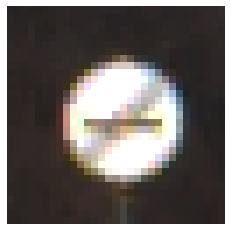

(3.0, 5.0)


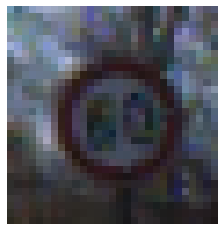

(18.0, 11.0)


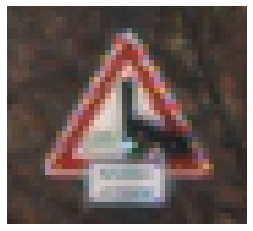

(26.0, 38.0)


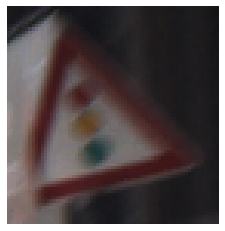

(3.0, 5.0)


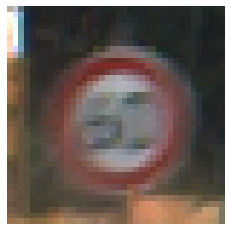

(3.0, 5.0)


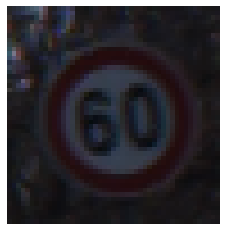

(26.0, 20.0)


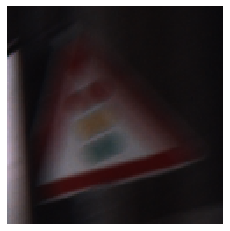

(3.0, 5.0)


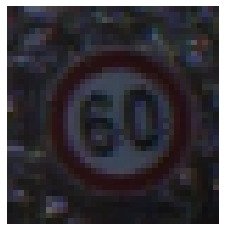

(41.0, 9.0)


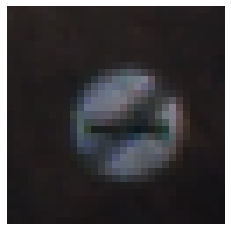

(18.0, 26.0)


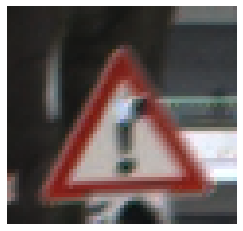

(18.0, 25.0)


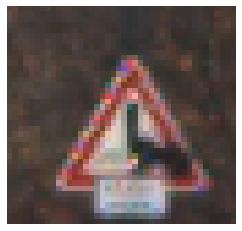

(3.0, 5.0)


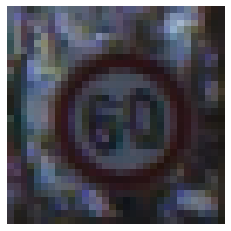

(26.0, 38.0)


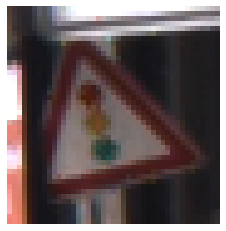

(18.0, 26.0)


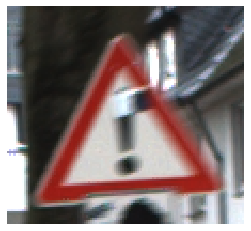

(41.0, 9.0)


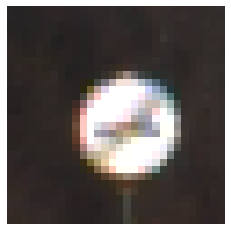

(18.0, 25.0)


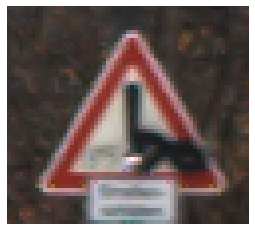

(18.0, 26.0)


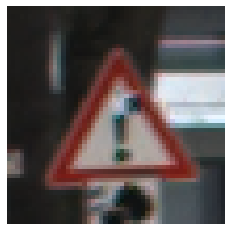

(26.0, 38.0)


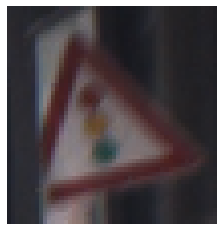

(18.0, 11.0)


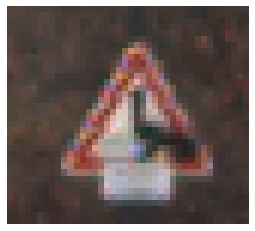

(26.0, 18.0)


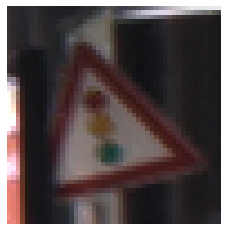

(3.0, 5.0)


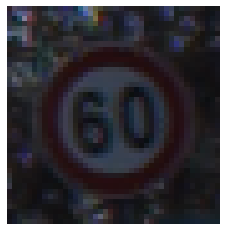

(26.0, 18.0)


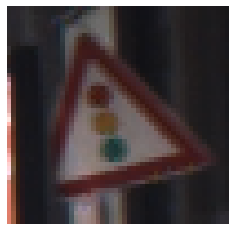

(3.0, 5.0)


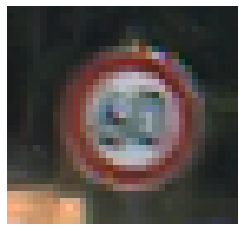

(3.0, 5.0)


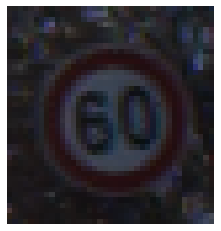

(41.0, 9.0)


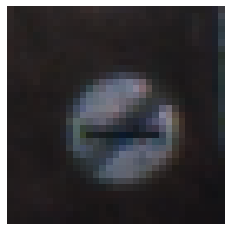

(3.0, 2.0)


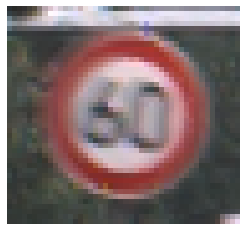

(41.0, 9.0)


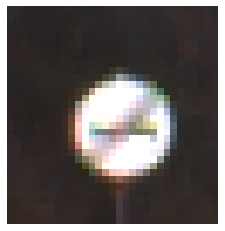

(18.0, 25.0)


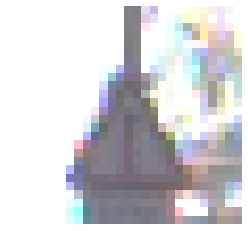

(3.0, 5.0)


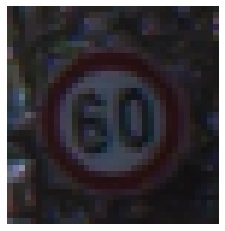

(41.0, 9.0)


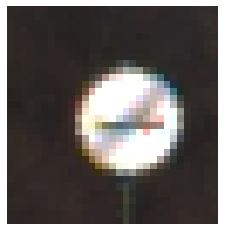

(18.0, 26.0)


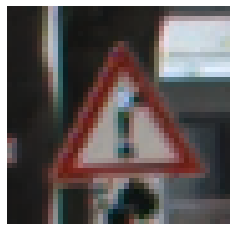

(3.0, 5.0)


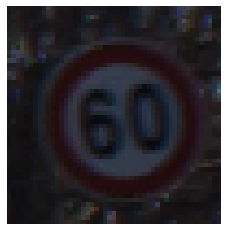

(26.0, 38.0)


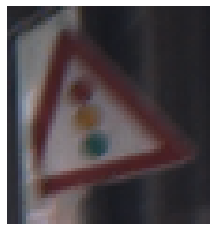

(3.0, 5.0)


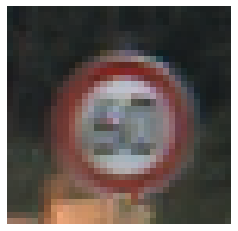

(18.0, 11.0)


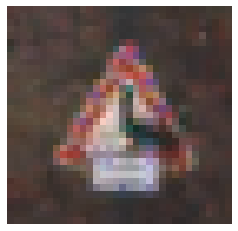

(18.0, 11.0)


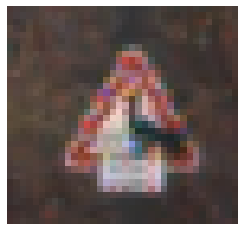

(18.0, 26.0)


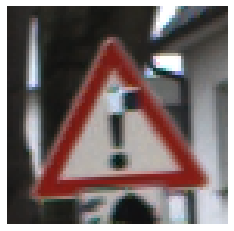

(41.0, 9.0)


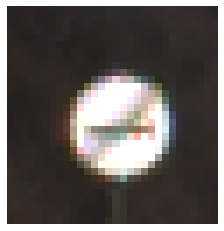

(3.0, 5.0)


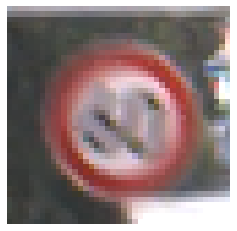

(26.0, 38.0)


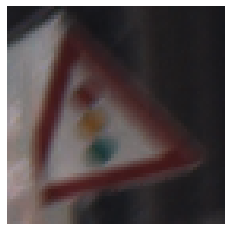

(41.0, 9.0)


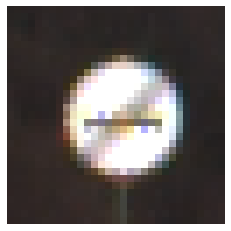

(3.0, 2.0)


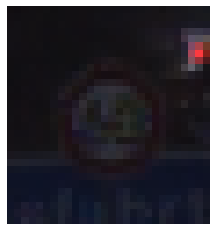

(3.0, 5.0)


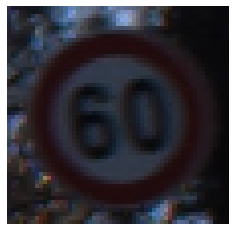

(18.0, 26.0)


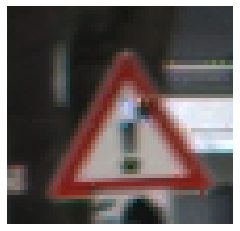

(3.0, 5.0)


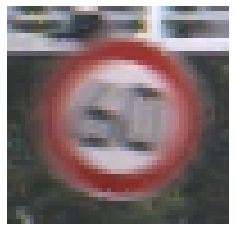

(3.0, 5.0)


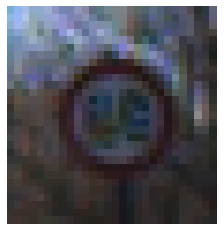

(26.0, 38.0)


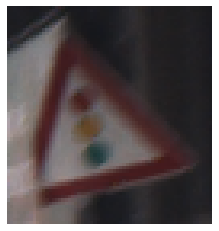

(18.0, 25.0)


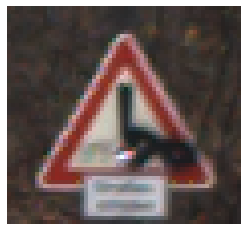

(18.0, 26.0)


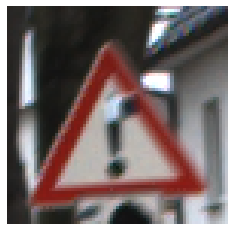

(18.0, 28.0)


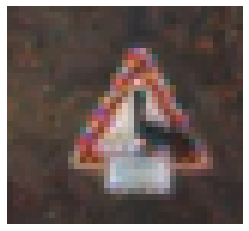

(18.0, 21.0)


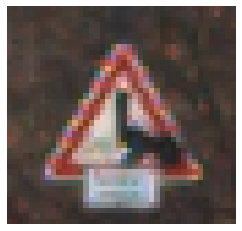

(26.0, 25.0)


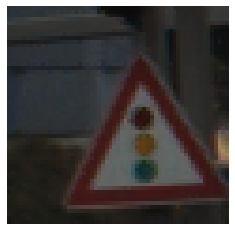

(3.0, 5.0)


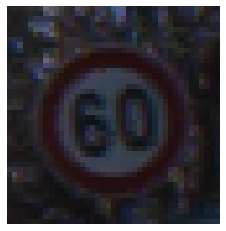

(18.0, 26.0)


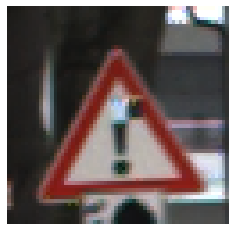

(3.0, 5.0)


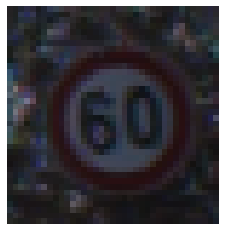

(26.0, 38.0)


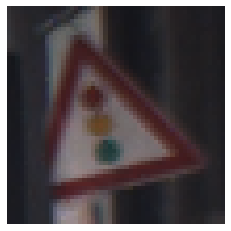

(3.0, 5.0)


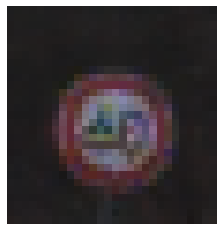

(18.0, 26.0)


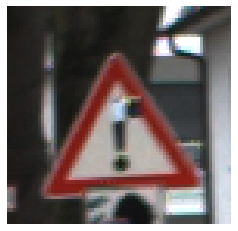

(18.0, 25.0)


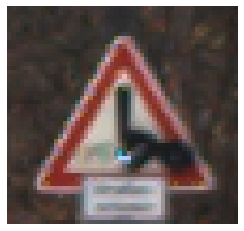

(26.0, 18.0)


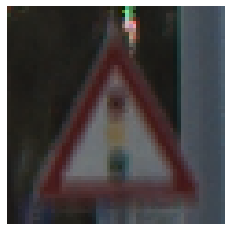

(18.0, 25.0)


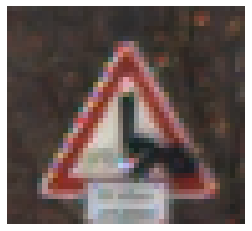

(3.0, 5.0)


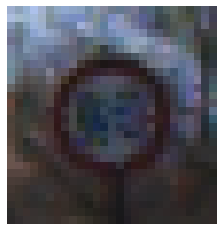

(26.0, 11.0)


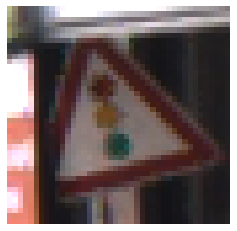

(26.0, 38.0)


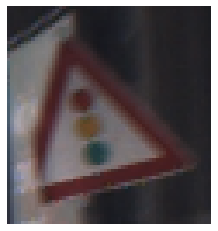

(41.0, 9.0)


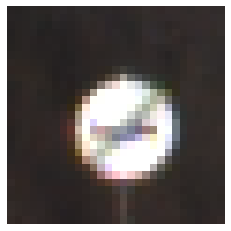

(26.0, 38.0)


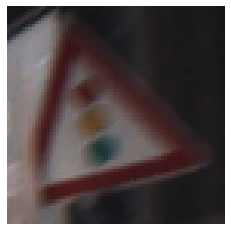

(26.0, 38.0)


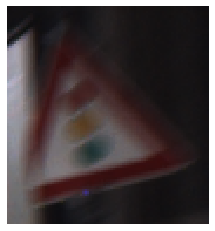

(3.0, 5.0)


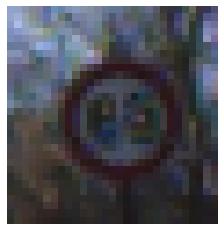

(41.0, 9.0)


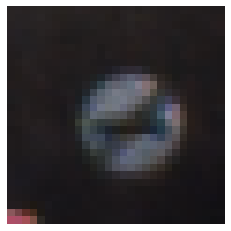

(26.0, 38.0)


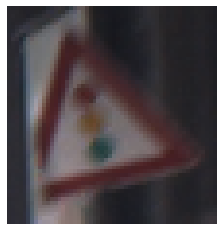

(18.0, 11.0)


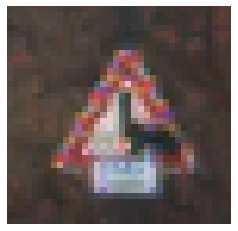

(26.0, 4.0)


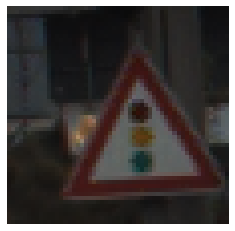

(3.0, 5.0)


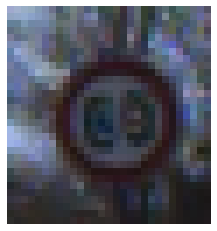

(18.0, 25.0)


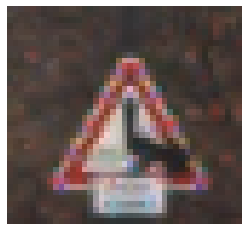

(3.0, 2.0)


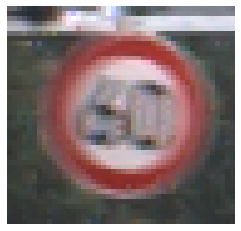

(41.0, 9.0)


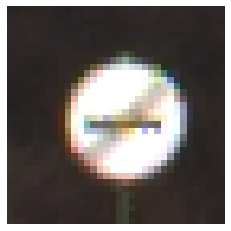

(26.0, 20.0)


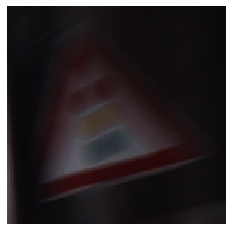

(3.0, 5.0)


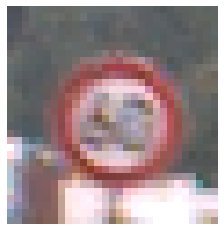

(18.0, 26.0)


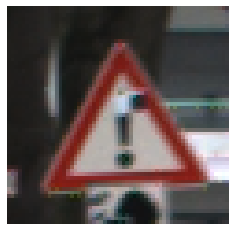

(3.0, 5.0)


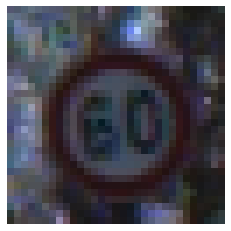

(3.0, 2.0)


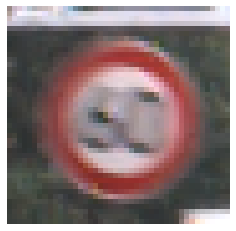

(3.0, 5.0)


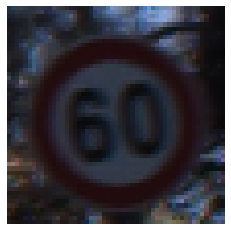

(18.0, 25.0)


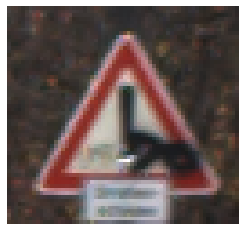

(26.0, 18.0)


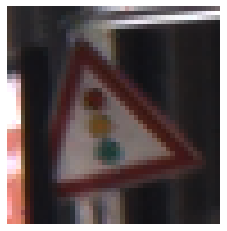

(18.0, 11.0)


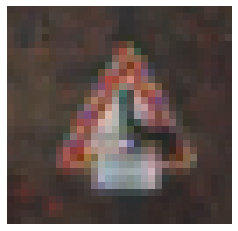

(18.0, 26.0)


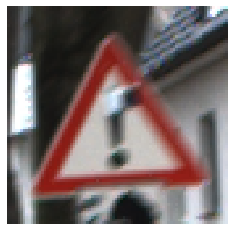

(3.0, 5.0)


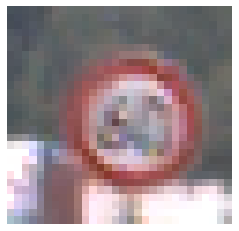

(26.0, 25.0)


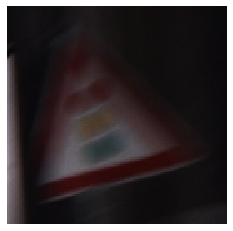

(3.0, 5.0)


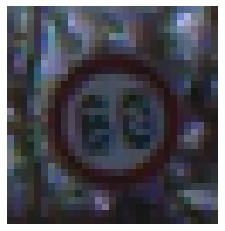

(26.0, 38.0)


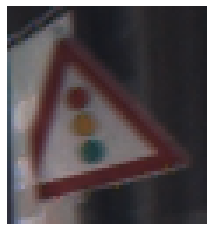

(3.0, 5.0)


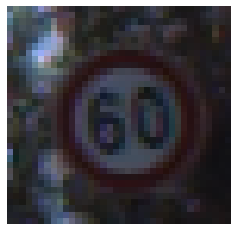

(41.0, 9.0)


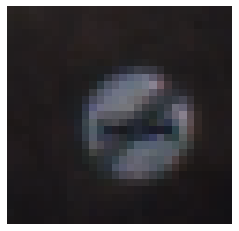

(3.0, 5.0)


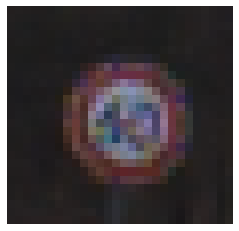

(3.0, 5.0)


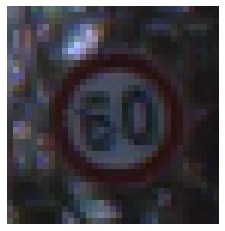

(26.0, 38.0)


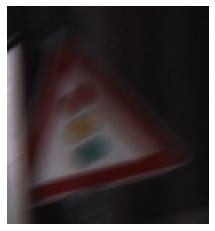

(26.0, 38.0)


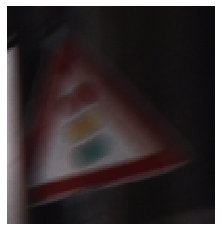

(41.0, 9.0)


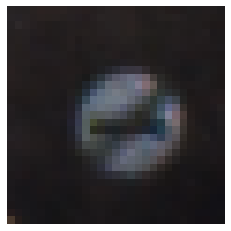

(18.0, 26.0)


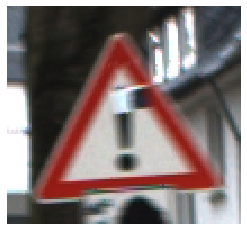

(3.0, 5.0)


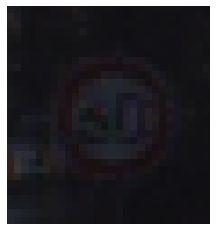

(18.0, 26.0)


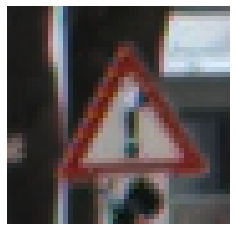

(3.0, 5.0)


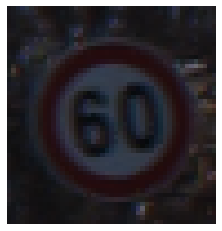

(18.0, 38.0)


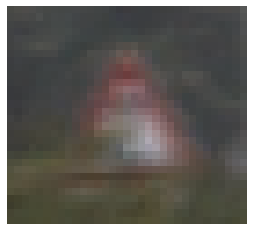

(18.0, 26.0)


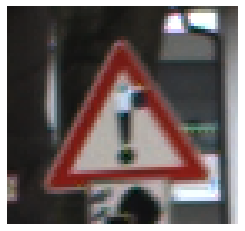

(18.0, 26.0)


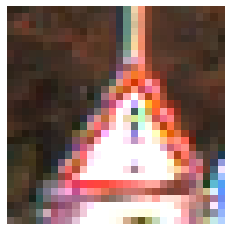

(18.0, 26.0)


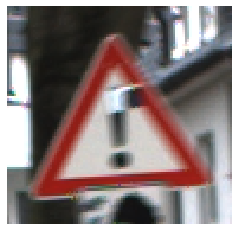

(41.0, 9.0)


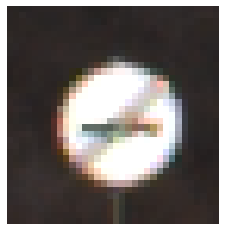

(41.0, 9.0)


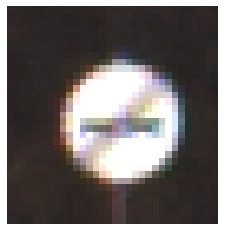

(3.0, 5.0)


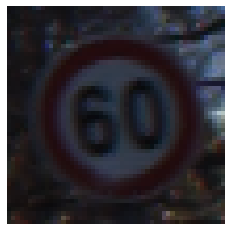

(18.0, 26.0)


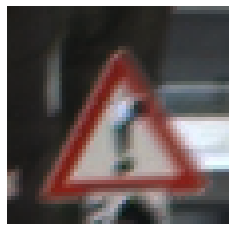

(26.0, 25.0)


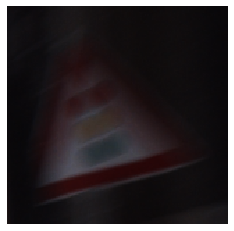

(26.0, 38.0)


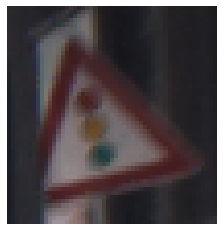

(41.0, 9.0)


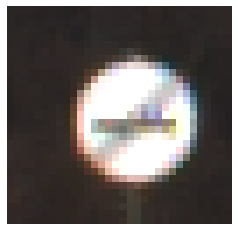

(18.0, 26.0)


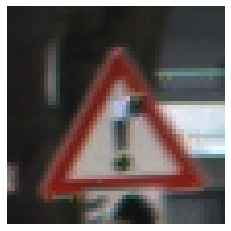

(18.0, 25.0)


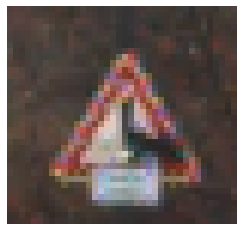

(3.0, 5.0)


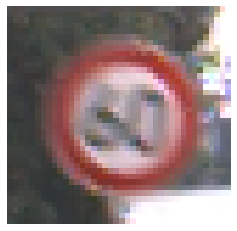

(41.0, 9.0)


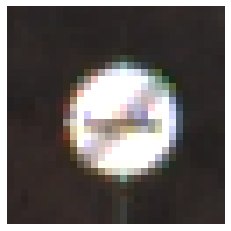

(18.0, 25.0)


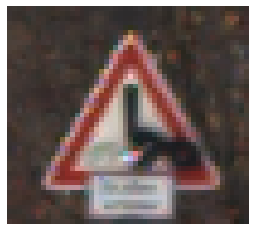

(18.0, 25.0)


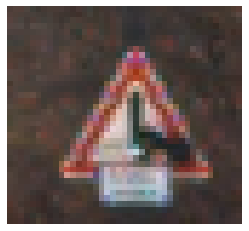

(3.0, 12.0)


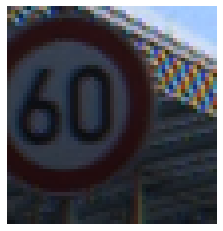

(18.0, 28.0)


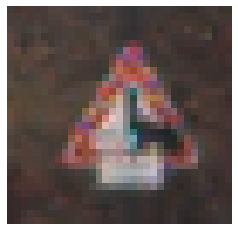

(26.0, 38.0)


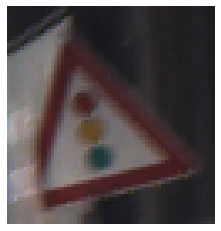

(41.0, 9.0)


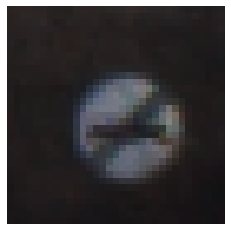

(18.0, 26.0)


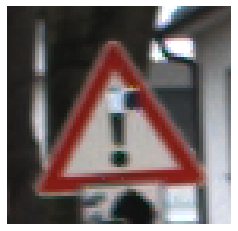

(18.0, 26.0)


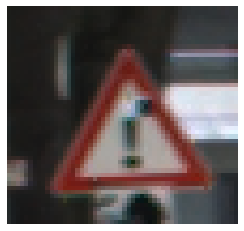

(26.0, 38.0)


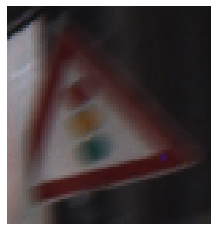

(18.0, 26.0)


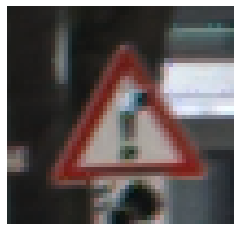

(3.0, 10.0)


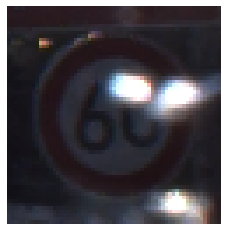

(3.0, 2.0)


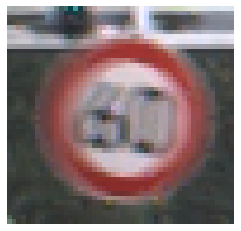

(3.0, 2.0)


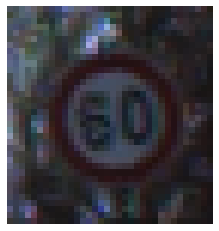

(26.0, 25.0)


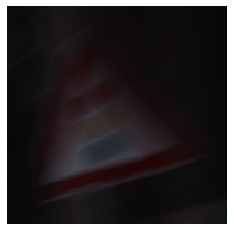

(26.0, 38.0)


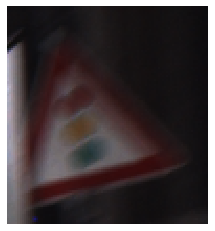

(26.0, 25.0)


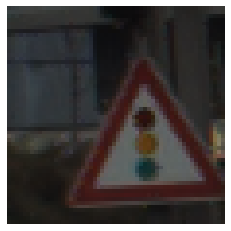

(18.0, 26.0)


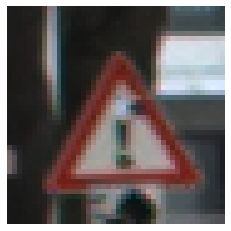

(18.0, 26.0)


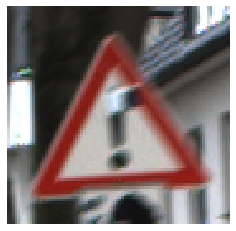

(26.0, 38.0)


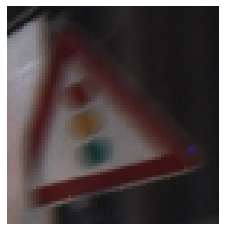

(26.0, 38.0)


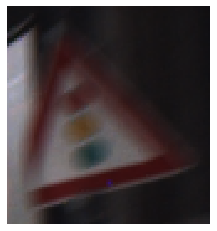

(3.0, 9.0)


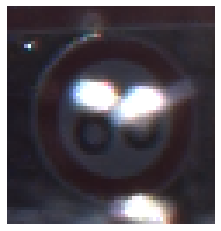

(3.0, 5.0)


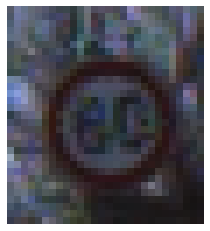

(3.0, 5.0)


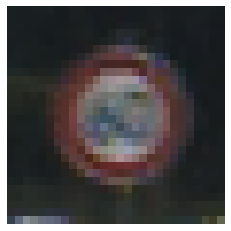

(18.0, 25.0)


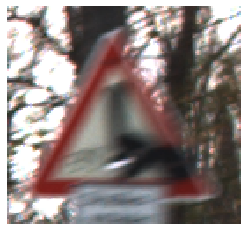

(18.0, 26.0)


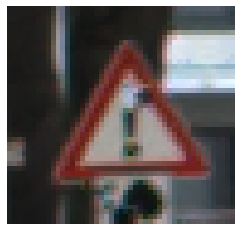

(18.0, 11.0)


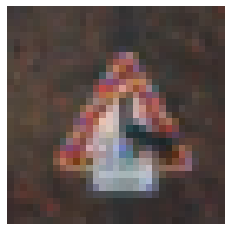

In [34]:
ShowFalseExamples(testLabelsOfficialHog, predicted_labels_rfc_best, testimg, set([3.0, 18.0, 26.0, 41.0]))

(8.0, 1.0)


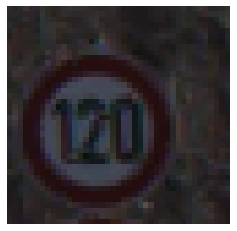

(7.0, 8.0)


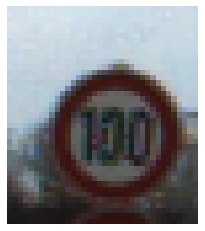

(30.0, 31.0)


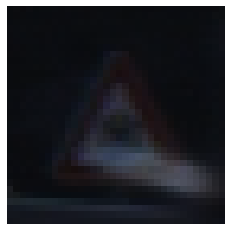

(30.0, 26.0)


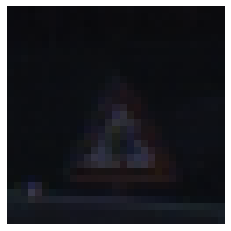

(30.0, 20.0)


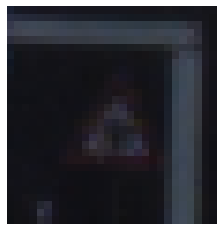

(8.0, 2.0)


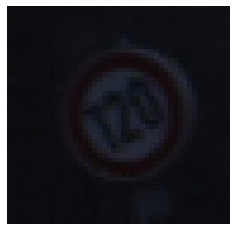

(30.0, 31.0)


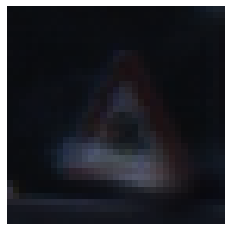

(7.0, 8.0)


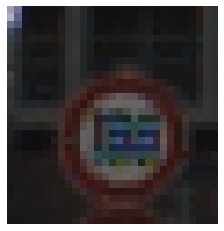

(5.0, 1.0)


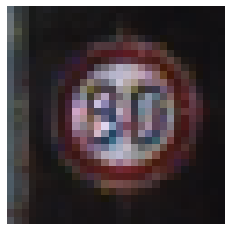

(8.0, 2.0)


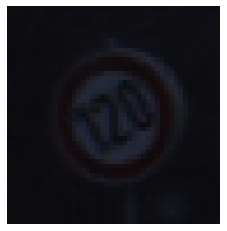

(30.0, 26.0)


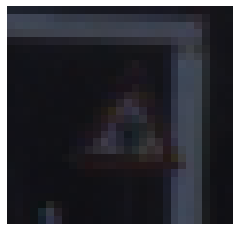

(30.0, 11.0)


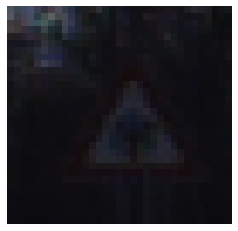

(5.0, 2.0)


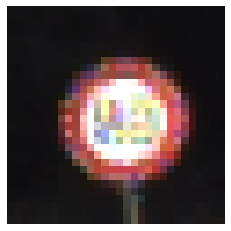

(30.0, 11.0)


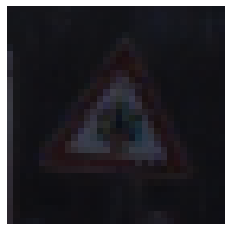

(30.0, 23.0)


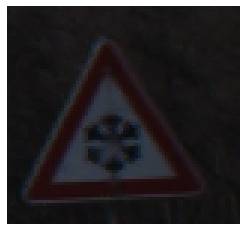

(30.0, 11.0)


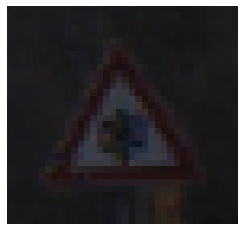

(7.0, 8.0)


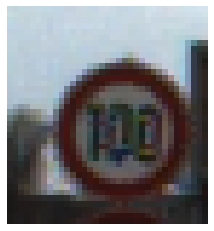

(30.0, 38.0)


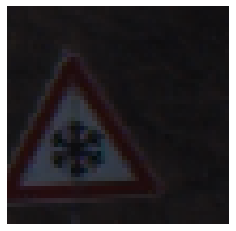

(5.0, 2.0)


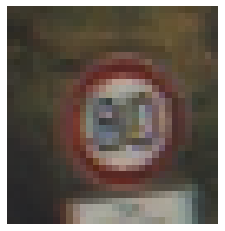

(5.0, 2.0)


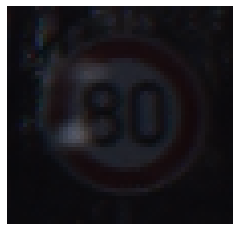

(5.0, 2.0)


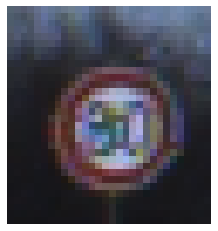

(30.0, 23.0)


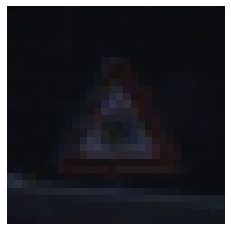

(5.0, 1.0)


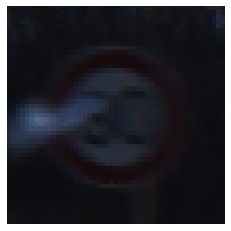

(30.0, 23.0)


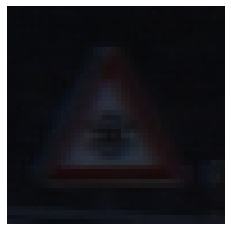

(7.0, 8.0)


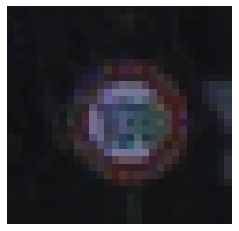

(30.0, 11.0)


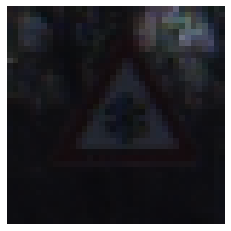

(8.0, 5.0)


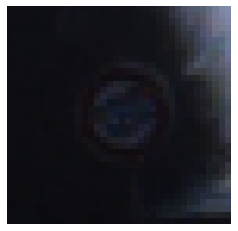

(5.0, 7.0)


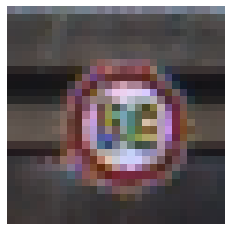

(30.0, 15.0)


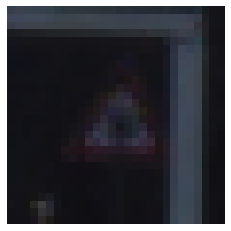

(8.0, 2.0)


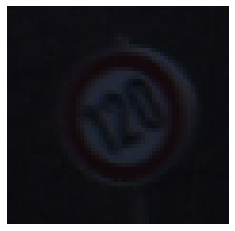

(30.0, 31.0)


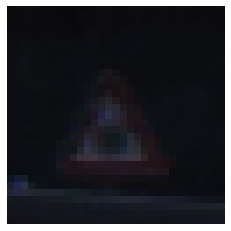

(30.0, 23.0)


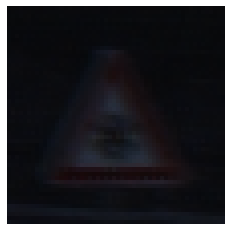

(5.0, 12.0)


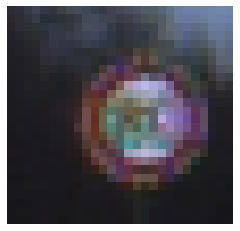

(7.0, 8.0)


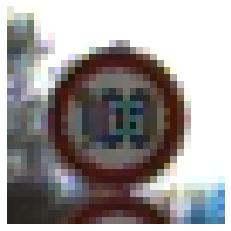

(8.0, 2.0)


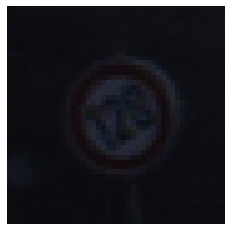

(30.0, 23.0)


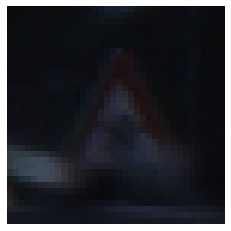

(8.0, 2.0)


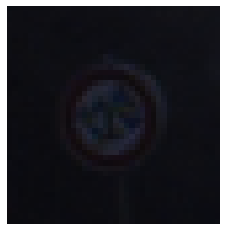

(8.0, 5.0)


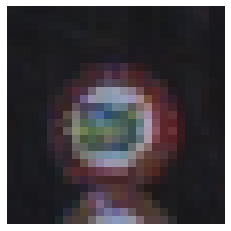

(30.0, 20.0)


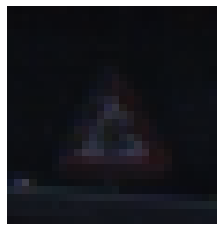

(30.0, 31.0)


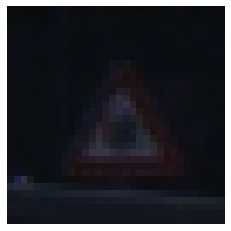

(5.0, 2.0)


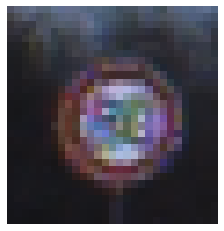

(8.0, 5.0)


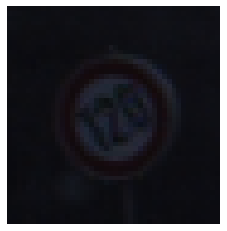

(30.0, 11.0)


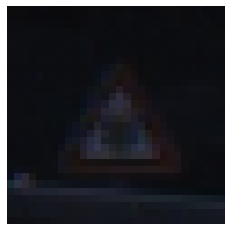

(30.0, 20.0)


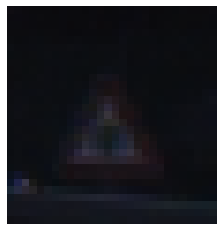

(5.0, 1.0)


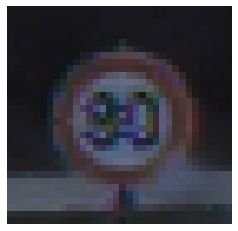

(8.0, 5.0)


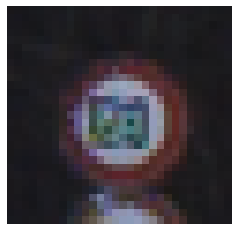

(30.0, 11.0)


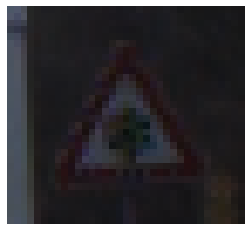

(5.0, 2.0)


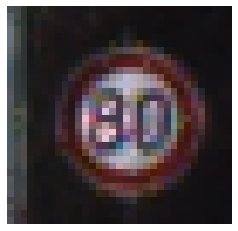

(30.0, 11.0)


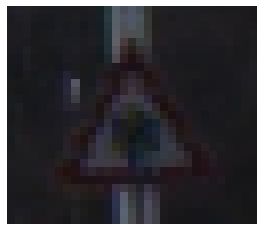

(5.0, 2.0)


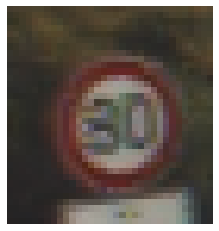

(7.0, 4.0)


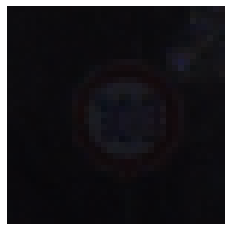

(7.0, 2.0)


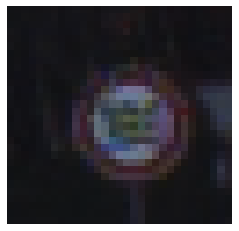

(30.0, 20.0)


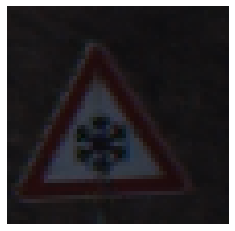

(8.0, 2.0)


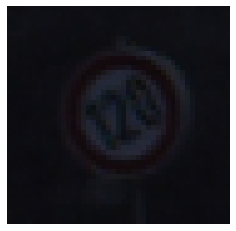

(7.0, 5.0)


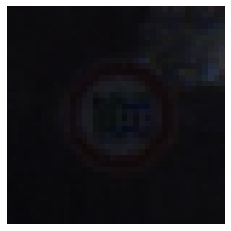

(7.0, 8.0)


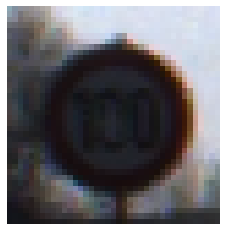

(8.0, 2.0)


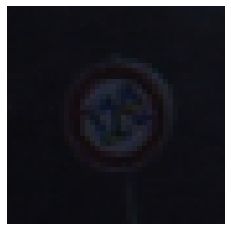

(30.0, 31.0)


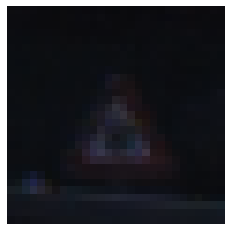

(30.0, 31.0)


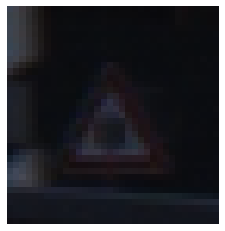

(7.0, 8.0)


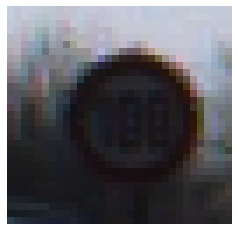

(8.0, 4.0)


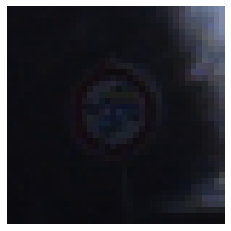

(7.0, 8.0)


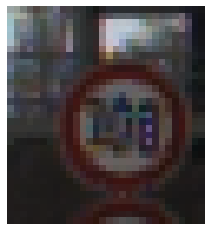

(5.0, 2.0)


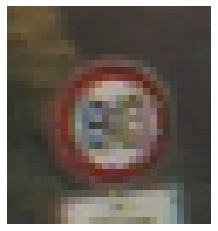

(5.0, 2.0)


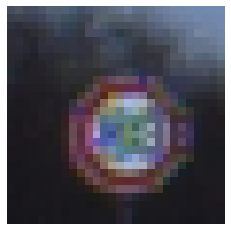

(8.0, 3.0)


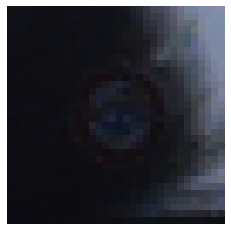

(5.0, 7.0)


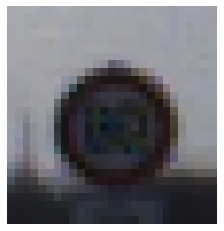

(7.0, 8.0)


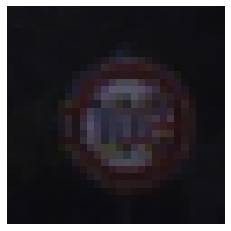

(30.0, 11.0)


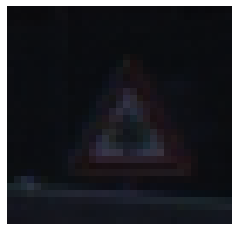

(30.0, 28.0)


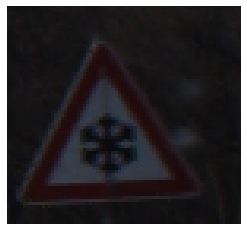

(5.0, 2.0)


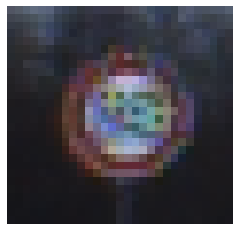

(30.0, 6.0)


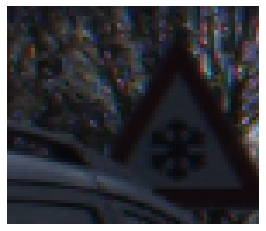

(5.0, 2.0)


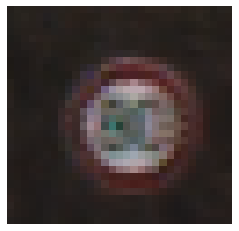

(30.0, 11.0)


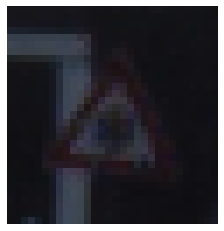

(7.0, 8.0)


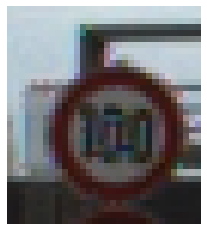

(30.0, 11.0)


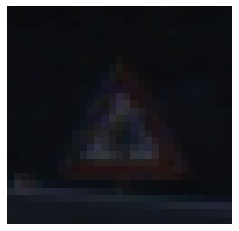

(8.0, 5.0)


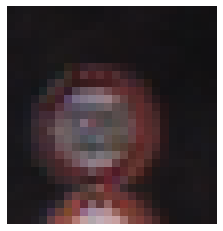

(7.0, 1.0)


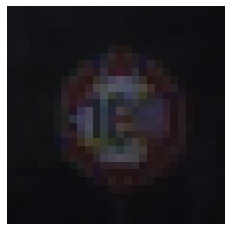

(7.0, 8.0)


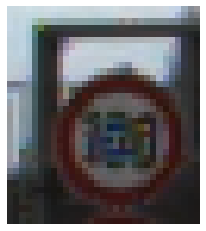

(8.0, 7.0)


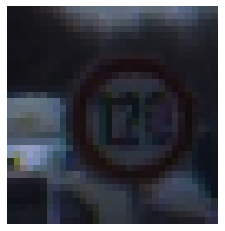

(5.0, 8.0)


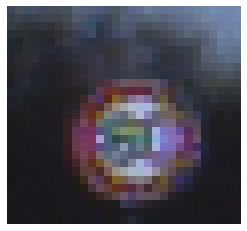

(8.0, 2.0)


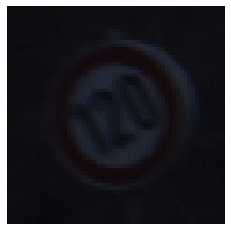

(30.0, 23.0)


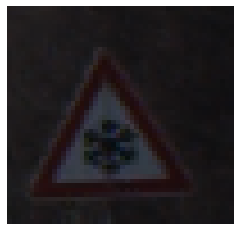

(7.0, 8.0)


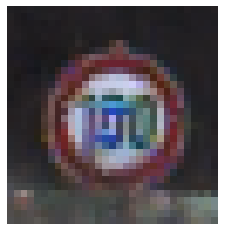

(7.0, 8.0)


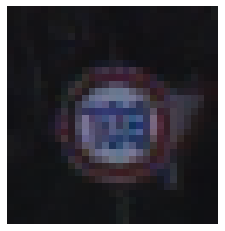

(8.0, 2.0)


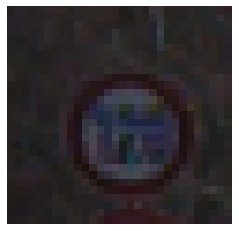

(8.0, 2.0)


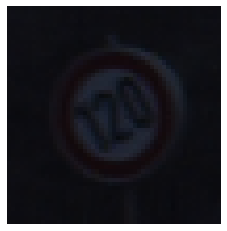

(5.0, 1.0)


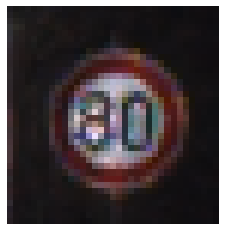

(30.0, 11.0)


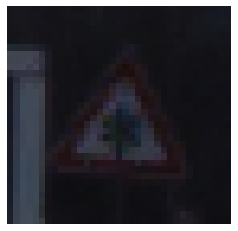

(5.0, 8.0)


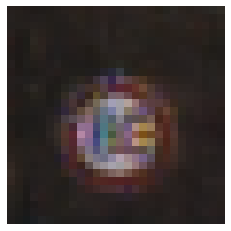

(5.0, 2.0)


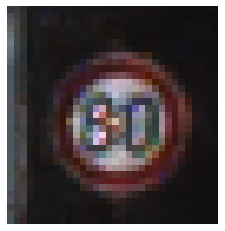

(30.0, 20.0)


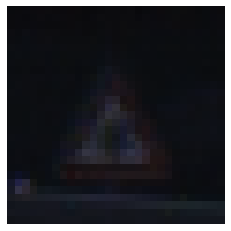

(30.0, 11.0)


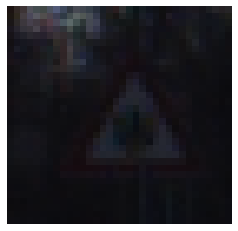

(8.0, 2.0)


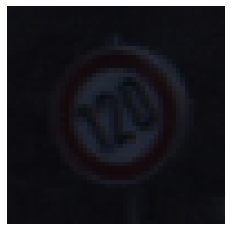

(7.0, 5.0)


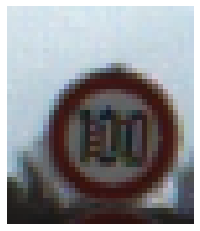

(30.0, 31.0)


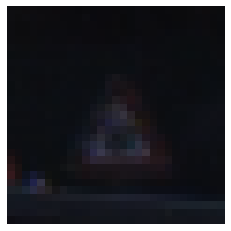

(5.0, 2.0)


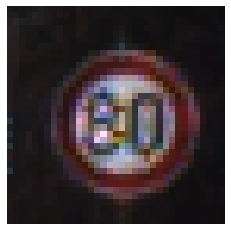

(5.0, 3.0)


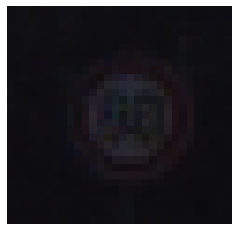

(30.0, 11.0)


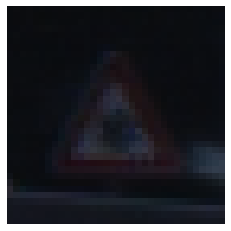

(8.0, 4.0)


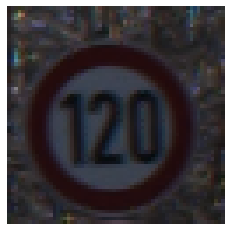

(8.0, 2.0)


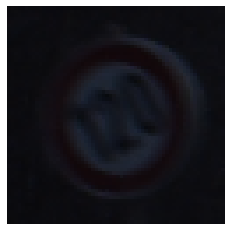

(7.0, 8.0)


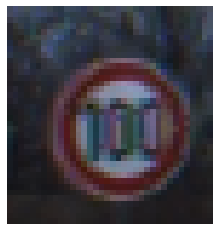

(30.0, 26.0)


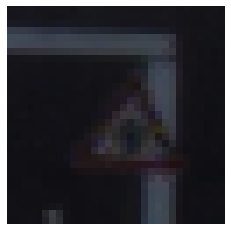

(8.0, 2.0)


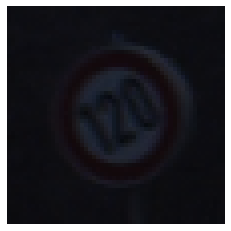

(30.0, 11.0)


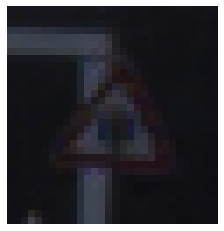

(8.0, 7.0)


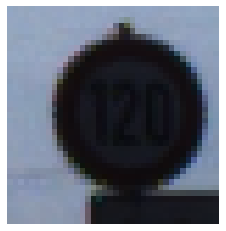

(8.0, 2.0)


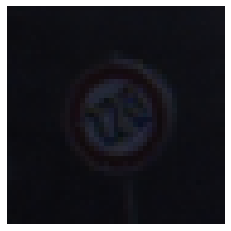

(5.0, 2.0)


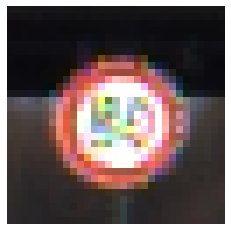

(30.0, 31.0)


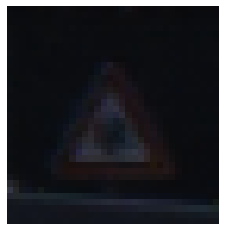

In [13]:
ShowFalseExamples(testLabelsOfficialHog, predicted_labels_rfc_best, testimg, set([5.0, 7.0, 8.0, 30.0]))

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def getLabelText(file):
    labels = []
    content = pd.read_csv(file)
    for name in content['SignName']:
        labels.append(name)
    return labels

def showConfusionMatrix(true_labels, predicated_labels, label_text):
    cm = confusion_matrix(true_labels, predicated_labels)
    confusion_df = pd.DataFrame(cm, index=label_text, columns=label_text)
    plt.figure(figsize = (50,30))
    sns.set(font_scale=3.0)
    ax = sns.heatmap(confusion_df, annot=True, cmap = "Blues", fmt="d", annot_kws={"size": 32})
    # fix clipping
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

Accuracy: 0.966270783847981


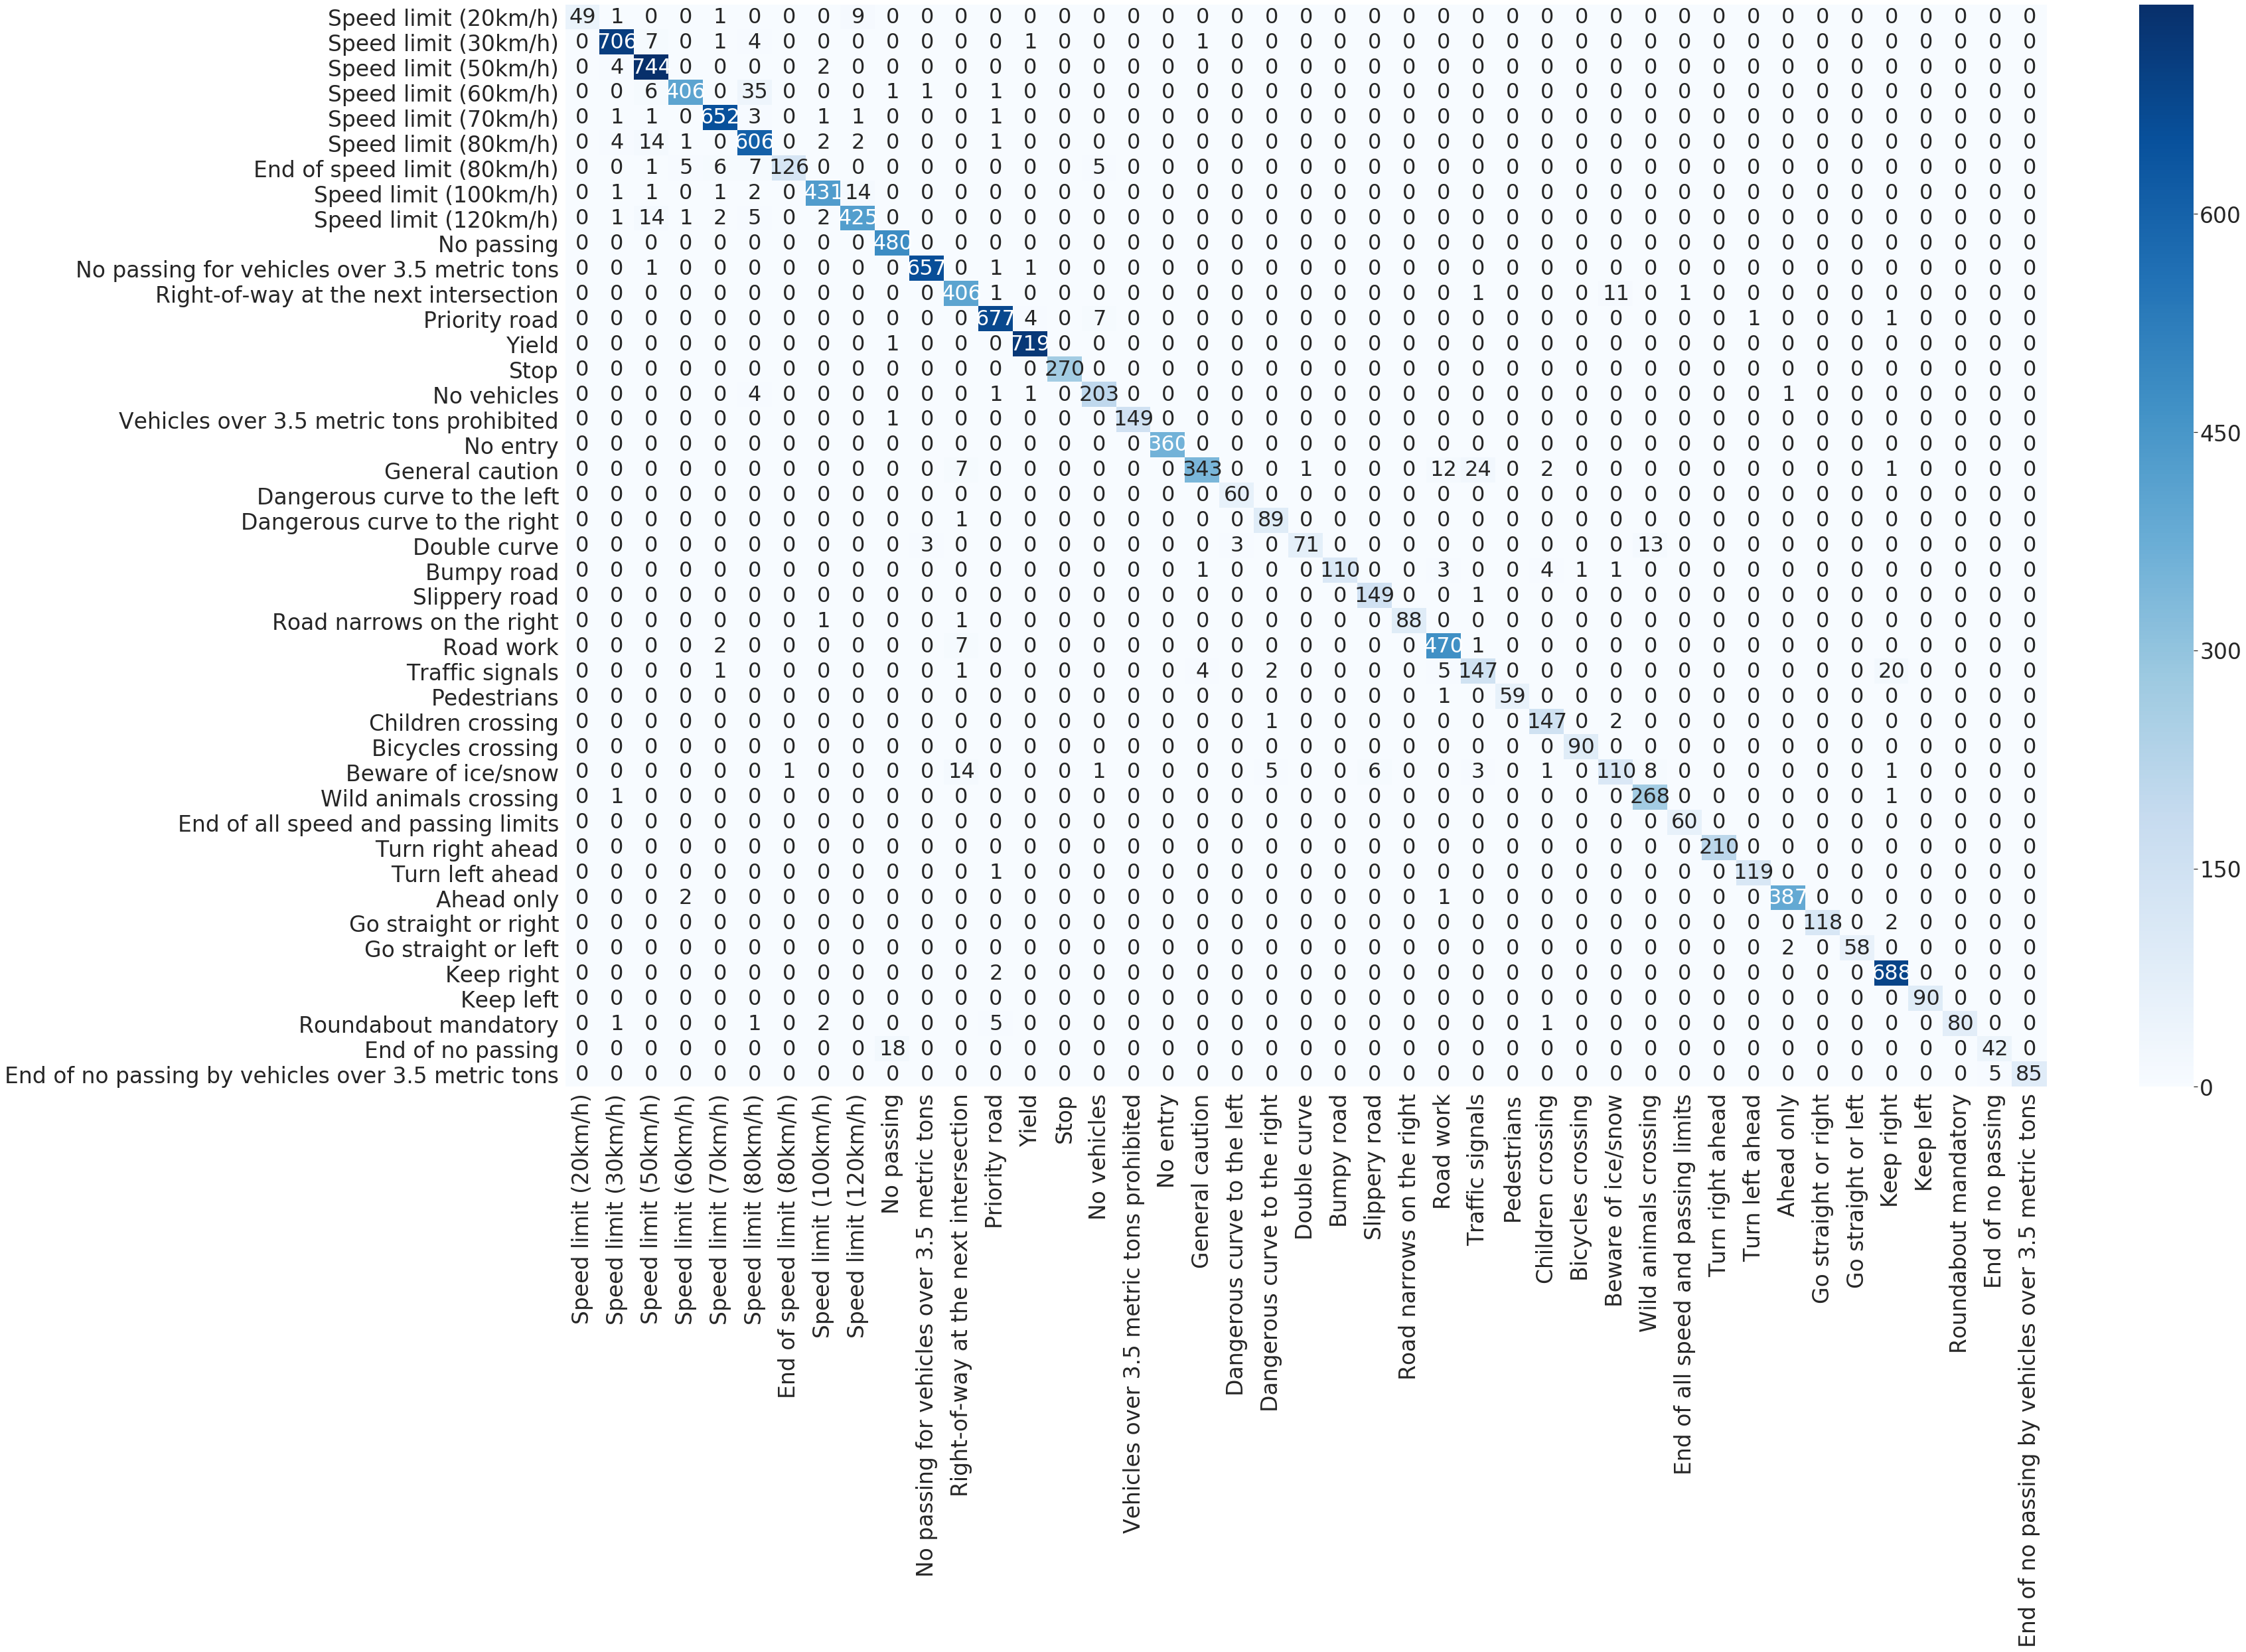

In [57]:
print("Accuracy: " + str(accuracy_score(testLabelsOfficialHog, predicted_labels_rfc_best)))
label_text = getLabelText('data/label_names.csv')
showConfusionMatrix(testLabelsOfficialHog, predicted_labels_rfc_best, label_text)